In [1]:
# Imports for NumPy, pandas, matplotlib, and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Notebook magic to inline plots
%matplotlib inline
# Store matplotlib plots as both png and pdf --> for 
# better quality graphics when exporting the notebook
# to pdf.
from IPython.display import set_matplotlib_formats
from IPython.display import Image, Video
set_matplotlib_formats('png', 'pdf')
# Load seaborn defaults
sns.set(rc={'figure.dpi':300})
sns.set_style("ticks")
sns.set_context("talk")

In [3]:
from scipy.stats import norm, rv_histogram

In [4]:
from scipy.optimize import minimize

In [5]:
from galibrate.sampled_parameter import SampledParameter
from galibrate import GAO

/home/blake/src/python/GAlibrate/galibrate/gao.py:11: RuntimeWarning: ------Running GAO with numba optimization.------
  warnings.warn("------Running GAO with numba optimization.------", RuntimeWarning)


In [6]:
def fragment_frequency(fragments):
    frag_counts, _edges = np.histogram(fragments, bins=edges)
    frag_freq = 100 * frag_counts / len(fragments)
    return frag_freq
    

In [7]:
def surface_ablation(initial, Pfrag, fsl, Ndsl):
    """The surface layer of particles is ablated and forms fragments.
    """
    rads = initial / 2
    Nfrag = int(Pfrag*len(rads))
    shell_width = fsl * rads[:Nfrag]
    rcore = rads[:Nfrag] - shell_width
    Dcore = 2 * rcore
    rsl = ( rads[:Nfrag]**3 - rcore**3)**(1/3)
    rfrag = rsl/(Ndsl)**(1/3)
    Dfrag = 2 * rfrag
    frag_list = list()
    for i in range(Ndsl):
        frag_list.append(Dfrag)
    frag_list.append(initial[Nfrag:])   
    frag_list.append(Dcore)
    fragments = np.concatenate(frag_list)
    return fragments

In [8]:
def cost_surface_ablation(params):
    Pfrag, fsl, Ndsl = params
    Ndsl = int(Ndsl)
    fragments = surface_ablation(sample_sizes, Pfrag, fsl, Ndsl)
    frequencies = fragment_frequency(fragments)
    sse = np.sum((dist['laser'] - frequencies)**2)
    if np.isnan(sse):
        return np.inf
    return sse

In [9]:
def fitness_surface_ablation(theta):
    return -cost_surface_ablation(10**theta)

In [10]:
sampled_parameters_sa = [SampledParameter(name="Pfrag", loc=np.log10(1e-2), width=2),
                         SampledParameter(name="fsl", loc=np.log10(6e-2), width=np.log10(10e-2)-np.log10(6e-2)),
                         SampledParameter(name="Ndsl", loc=np.log10(1), width=3)]

In [11]:
def particle_split(initial, Pfrag, Nd):
    """Particles get split into equal volume fragments.
    """    
    rads = initial / 2
    Vo = (4/3)*np.pi*rads**3
    Nfrag = int(Pfrag*len(rads))
    Vfrag = Vo[:Nfrag] / Nd
    rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
    Dfrag = rfrag*2
    frag_list = list()
    for i in range(Nd):
        frag_list.append(Dfrag)
    frag_list.append(initial[Nfrag:])    
    fragments = np.concatenate(frag_list)
    return fragments

In [12]:
def cost_particle_split(params):
    Pfrag, Nd = params
    Nd = int(Nd)
    fragments = particle_split(sample_sizes, Pfrag, Nd)
    frequencies = fragment_frequency(fragments)
    sse = np.sum((dist['laser'] - frequencies)**2)
    if np.isnan(sse):
        return np.inf
    return sse

In [13]:
def fitness_particle_split(theta):
    return -cost_particle_split(10**theta)

In [14]:
sampled_parameters_ps = [SampledParameter(name="Pfrag", loc=np.log10(1e-2), width=2),
                         SampledParameter(name="Nd", loc=np.log10(2), width=3)]

In [15]:
def surface_ablation_unequal(initial, Pfrag, fsl, Ndsl):
    """The surface layer of particles is ablated and forms fragments of unequal size.
    """
    rads = initial / 2
    Nfrag = int(Pfrag*len(rads))
    shell_width = fsl * rads[:Nfrag]
    rcore = rads[:Nfrag] - shell_width
    Dcore = 2 * rcore
    frag_list = list()
    Vsl = (4/3)*np.pi * ( rads[:Nfrag]**3 - rcore**3)
    np.random.seed(1990)
    for vsl in Vsl:
        V_rand = np.random.random(Ndsl-1) * vsl
        V_rand = np.concatenate(([0], V_rand, [vsl]))
        V_rand.sort()
        V_frags = V_rand[1:] - V_rand[:-1]
        r_frags = ((3/(4*np.pi)) * V_frags)**(1/3)
        D_frags = 2 * r_frags
        frag_list.append(D_frags)
    frag_list.append(initial[Nfrag:])
    frag_list.append(Dcore)
    fragments = np.concatenate(frag_list)
    return fragments

In [16]:
def cost_surface_ablation_unequal(params):
    Pfrag, fsl, Ndsl = params
    Ndsl = int(Ndsl)
    fragments = surface_ablation_unequal(sample_sizes, Pfrag, fsl, Ndsl)
    frequencies = fragment_frequency(fragments)
    sse = np.sum((dist['laser'] - frequencies)**2)
    if np.isnan(sse):
        return np.inf
    return sse

In [17]:
def fitness_surface_ablation_unequal(theta):
    return -cost_surface_ablation_unequal(10**theta)

In [18]:
def particle_split_unequal(initial, Pfrag, Nd):
    """The surface layer of particles is ablated and forms fragments of unequal size.
    """
    rads = initial / 2
    Vo = (4/3)*np.pi*rads**3
    Nfrag = int(Pfrag*len(rads))
    Vfrag = Vo[:Nfrag]
    frag_list = list()
    np.random.seed(1991)
    for vsl in Vfrag:
        V_rand = np.random.random(Nd-1) * vsl
        V_rand = np.concatenate(([0], V_rand, [vsl]))
        V_rand.sort()
        V_frags = V_rand[1:] - V_rand[:-1]
        r_frags = ((3/(4*np.pi)) * V_frags)**(1/3)
        D_frags = 2 * r_frags
        frag_list.append(D_frags)
    frag_list.append(initial[Nfrag:])
    fragments = np.concatenate(frag_list)
    return fragments

In [19]:
def cost_particle_split_unequal(params):
    Pfrag, Nd = params
    Nd = int(Nd)
    fragments = particle_split_unequal(sample_sizes, Pfrag, Nd)
    frequencies = fragment_frequency(fragments)
    sse = np.sum((dist['laser'] - frequencies)**2)
    if np.isnan(sse):
        return np.inf
    return sse

In [20]:
def fitness_particle_split_unequal(theta):
    return -cost_particle_split_unequal(10**theta)

# 5 nm

In [21]:
# Load the data
dist = pd.read_csv('5nm_distribution.csv')
dist.head()

,size,initial,laser
0,0.4,0.0,0.00000
1,0.8,0.0,0.00000
2,1.2,0.0,0.64103
3,1.6,0.0,5.76923
4,2.0,0.0,10.89744


In [22]:
# Get the histogram bin centers
centers = dist['size'].to_numpy()
centers

array([ 0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,  4.4,
        4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,
        9.2,  9.6, 10. ])

In [23]:
# Histogram bin width
bw = centers[1] - centers[0]
bw

0.4

In [24]:
# Create the corresponding edges for the histogram
edges = np.linspace(centers[0] - 0.5*bw, centers[-1] + 0.5*bw, len(centers)+1, endpoint=True)
edges

array([ 0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,
        4.6,  5. ,  5.4,  5.8,  6.2,  6.6,  7. ,  7.4,  7.8,  8.2,  8.6,
        9. ,  9.4,  9.8, 10.2])

In [25]:
# Create a distribution object from the histogrammed frequencies.
rv_initial = rv_histogram((dist['initial'].to_numpy(), edges))
rv_initial

In [26]:
sample_sizes = rv_initial.rvs(size=10000, random_state=14983)
sample_sizes[:10]

array([5.64829151, 5.60571417, 5.15957694, 5.7913165 , 5.48697749,
       6.36852266, 5.16057654, 5.4210436 , 5.46593503, 5.84547406])

[0. 0. 0. 0. 0.]


(0, 40)

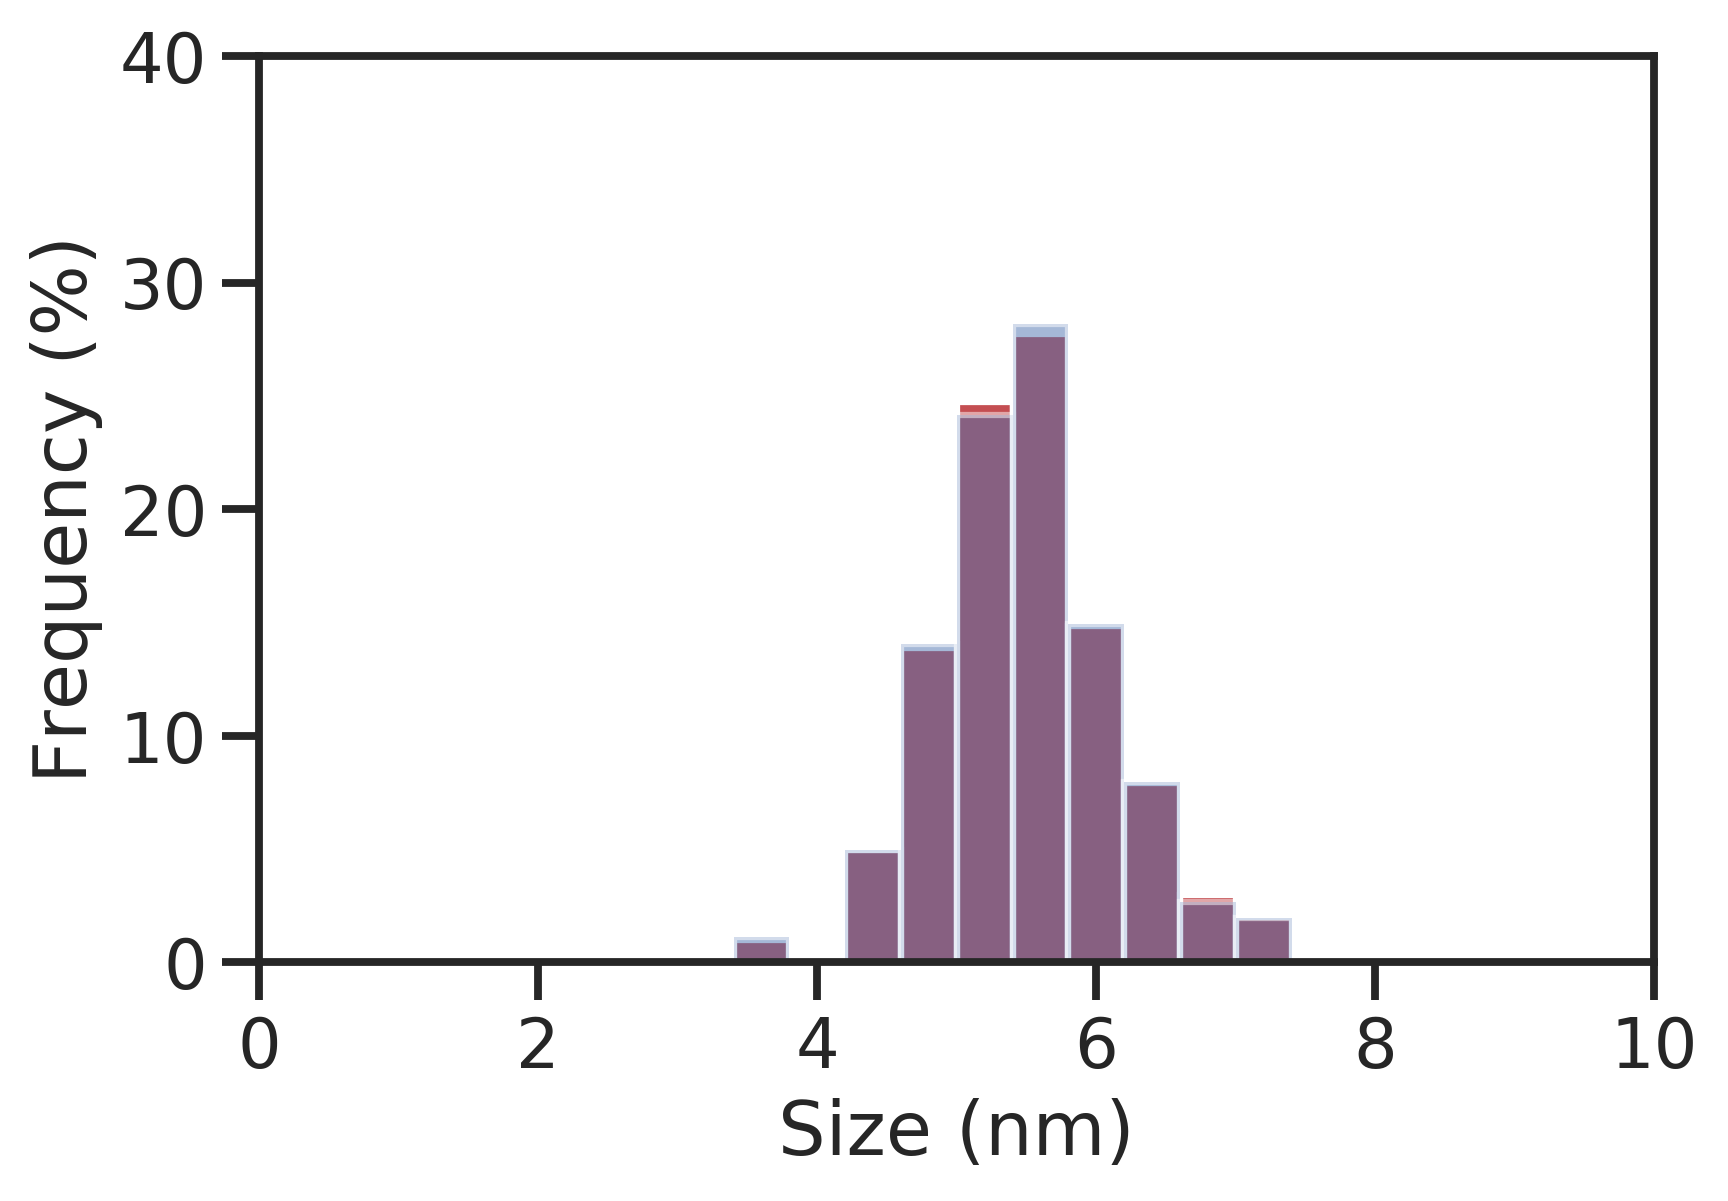

In [27]:
counts, _edges = np.histogram(sample_sizes, bins=edges)

freq = 100 * counts / len(sample_sizes)
print(freq[:5])
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.hist(centers, bins=edges, weights=freq, color='b', alpha=0.5)
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

(0, 40)

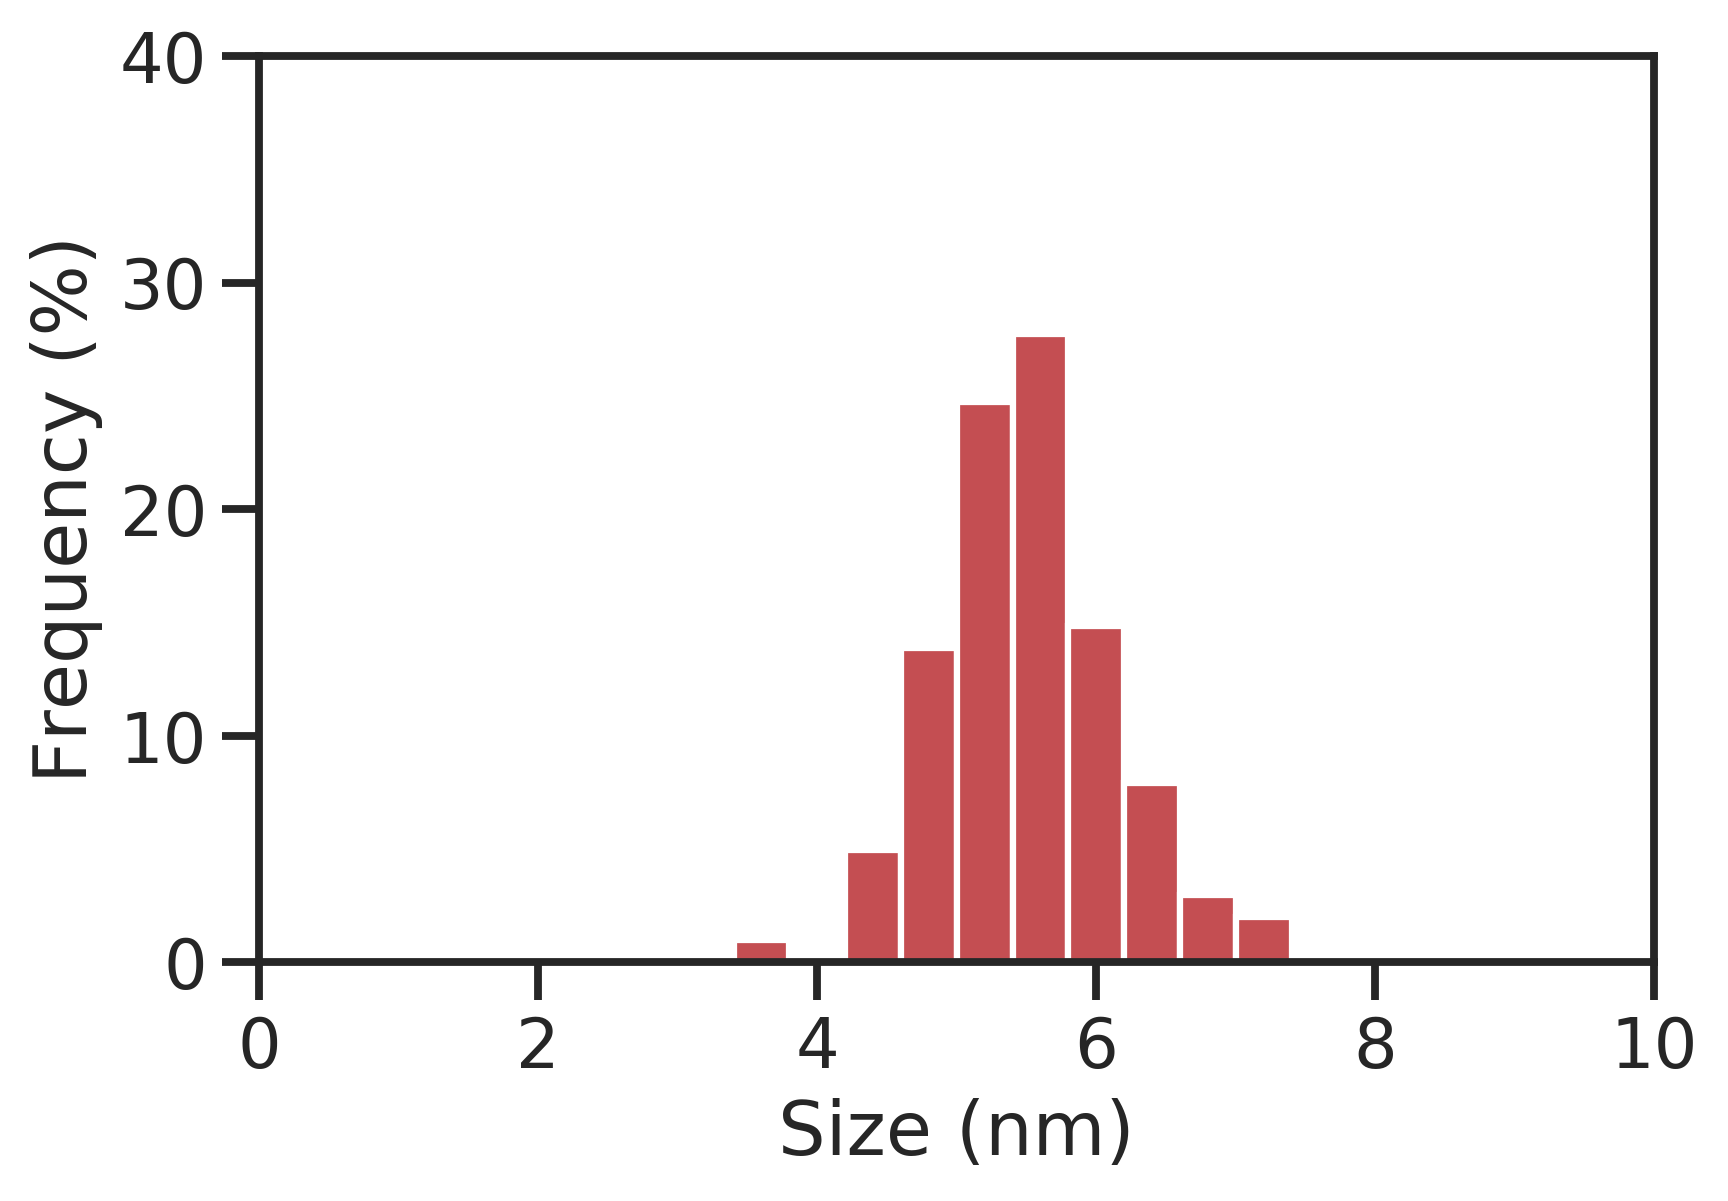

In [28]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

## Surface Layer Ablation - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [29]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [30]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

In [31]:
#nrepeats = 3
# Set the active point population size
population_size = 1000
#fit_parms_rep = list()
#fit_cost_rep = list()
#for rep in range(nrepeats):
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)
#    fit_parms_rep.append(fit_parms)
#    fit_cost_rep.append(fit_cost)
#fit_parms_rep = np.array(fit_parms_rep)
#fit_cost_rep = np.array(fit_cost_rep)
#fit_parms = fit_parms_rep.mean(axis=0)
#fit_parms_err = fit_parms_rep.std(axis=0)/np.sqrt(nrepeats)
#fit_cost = fit_cost_rep.mean()
#print(fit_parms, fit_parms_err, fit_cost)

Generations: 100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


[0.14751881 0.09928416 4.49759711] 447.29494959879855


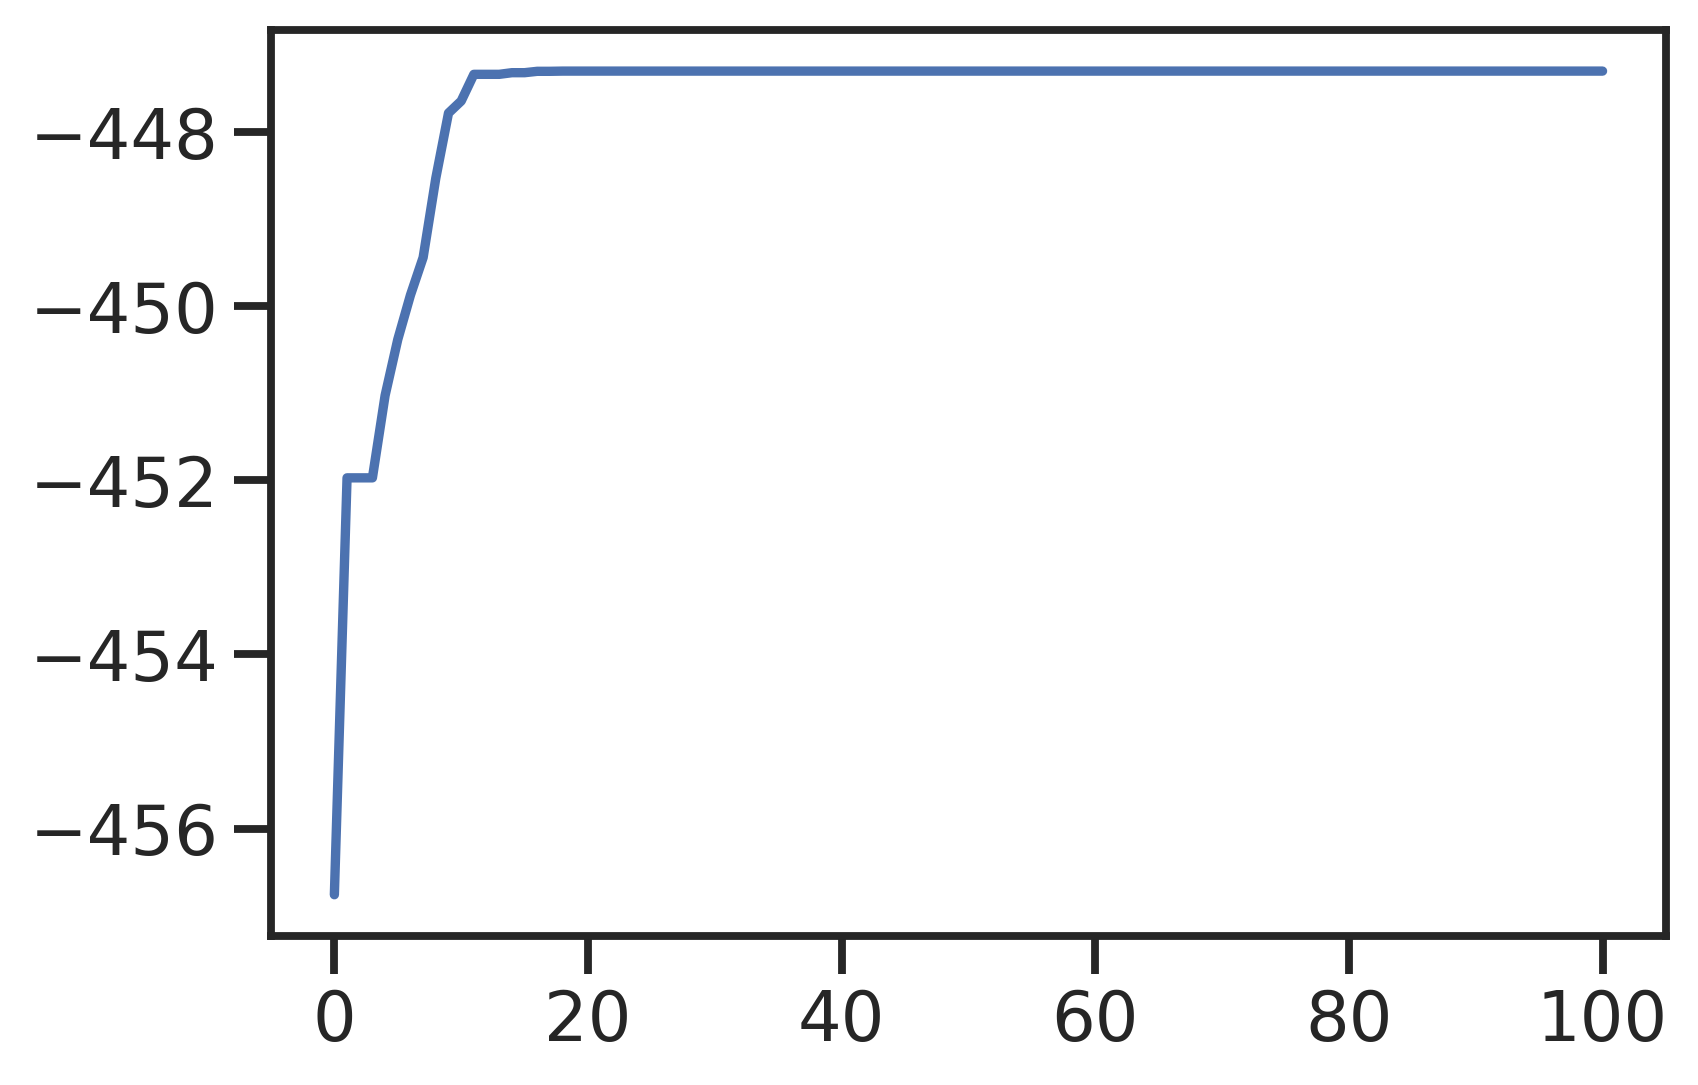

In [32]:
plt.plot(gao.best_fitness_per_generation)

In [33]:
AIC_sa = 2*len(fit_parms) + fit_cost
AIC_sa

453.29494959879855

In [34]:
fragments = surface_ablation(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

(0, 25)

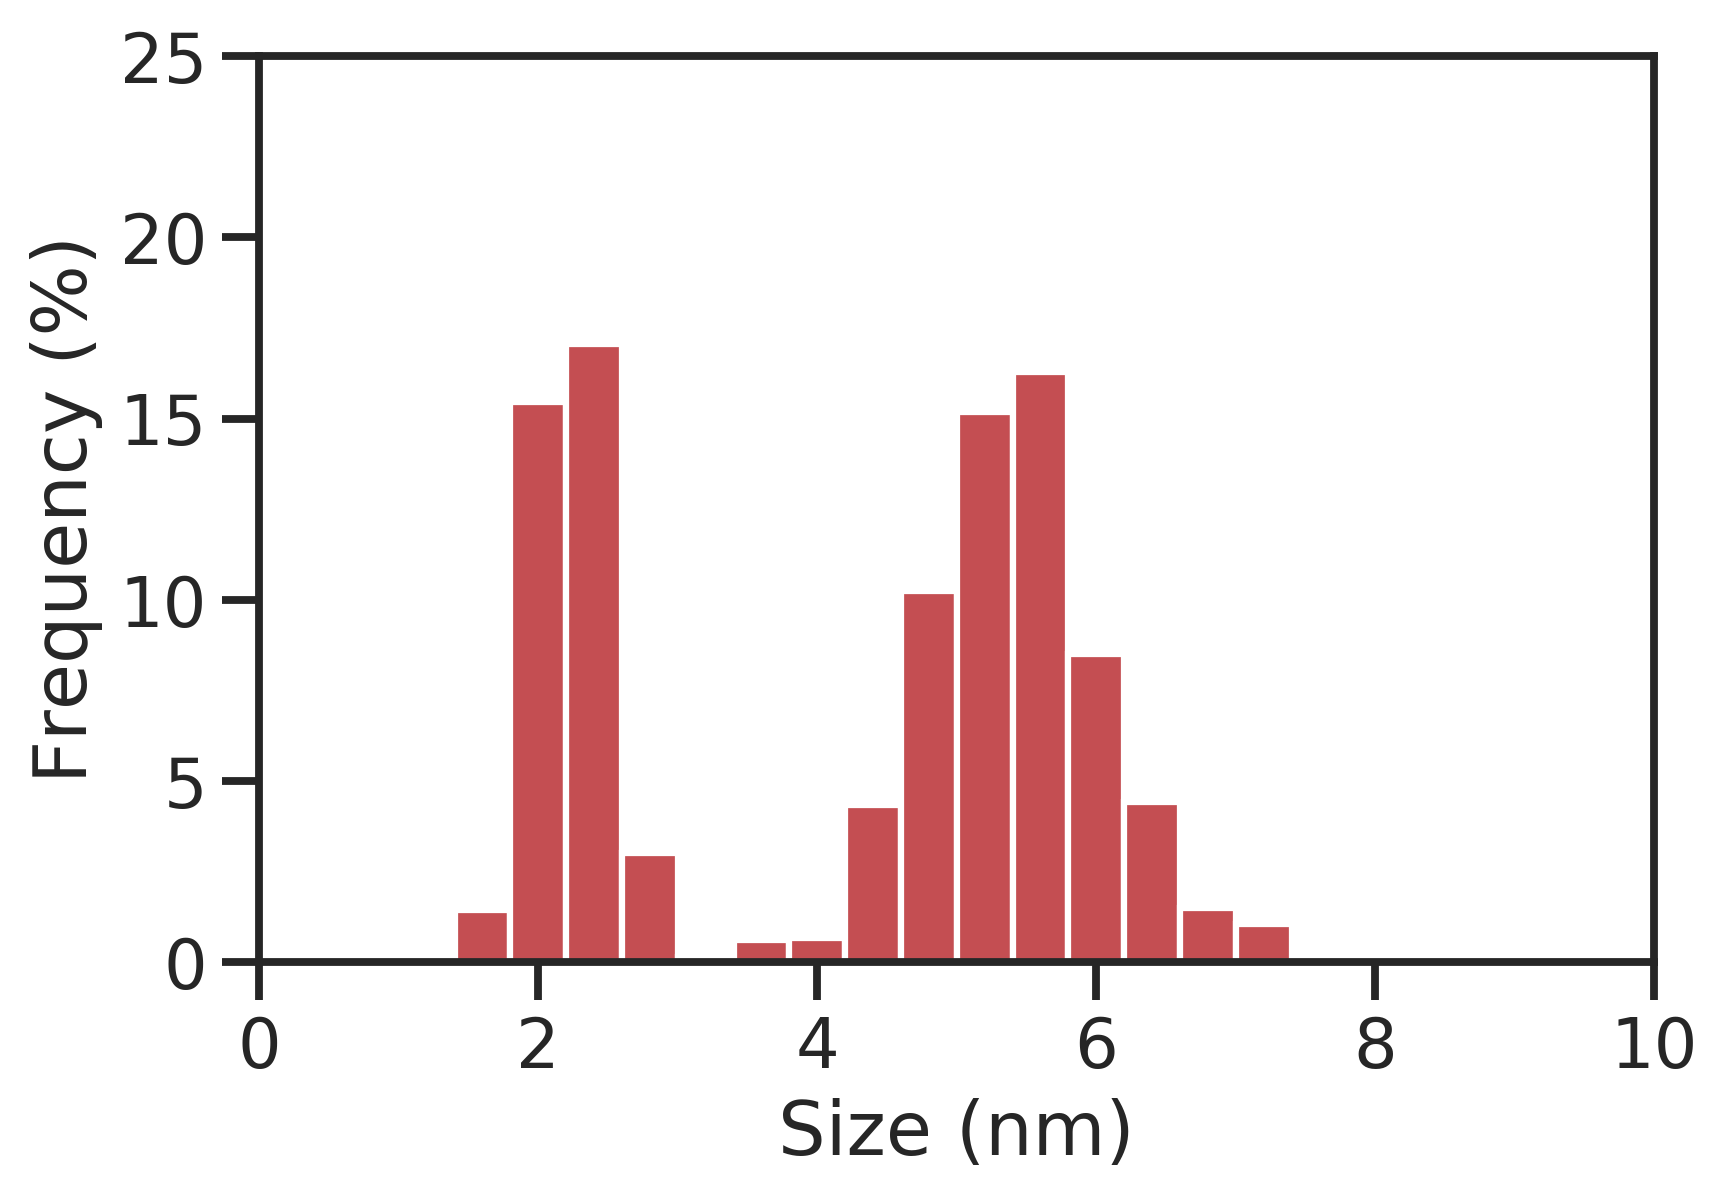

In [35]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,25))

In [36]:
np.savetxt('5nm_nlsfit_centers.txt', centers)
np.savetxt('5nm_nlsfit_edges.txt', edges)
np.savetxt('5nm_nlsfit_frequency_sa.txt', frag_freq)

Text(1, 22, 'SSE=447')

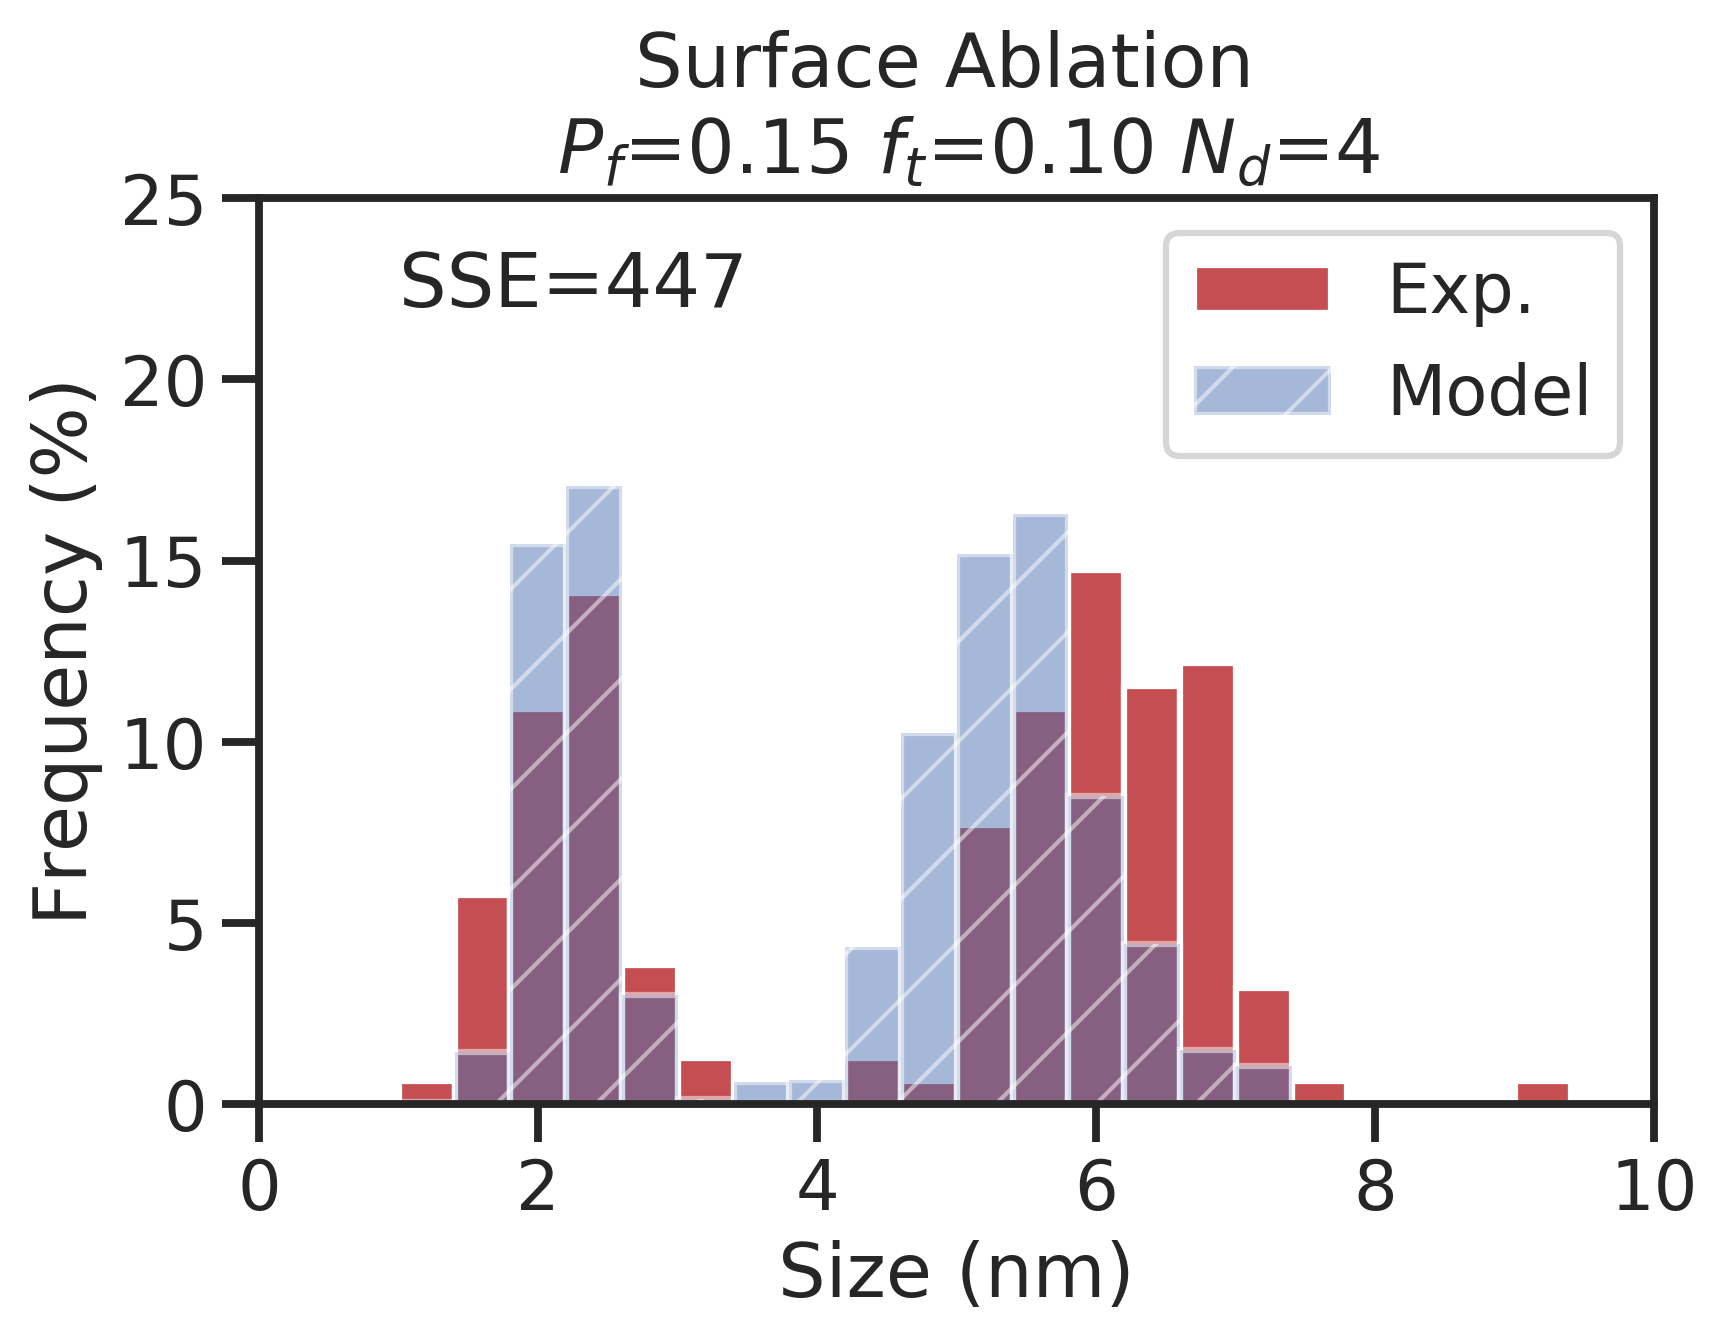

In [37]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))
plt.title("Surface Ablation \n $P_f$={:.2f} $f_t$={:.2f} $N_d$={}".format(fit_parms[0], fit_parms[1], int(fit_parms[2])))
plt.text(1,22, "SSE={:.0f}".format(fit_cost))

## Particle Split - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [38]:
# Set the active point population size
population_size = 1000
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_ps, fitness_particle_split, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)

Generations: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


[ 0.03978024 14.24374749] 410.217089180471


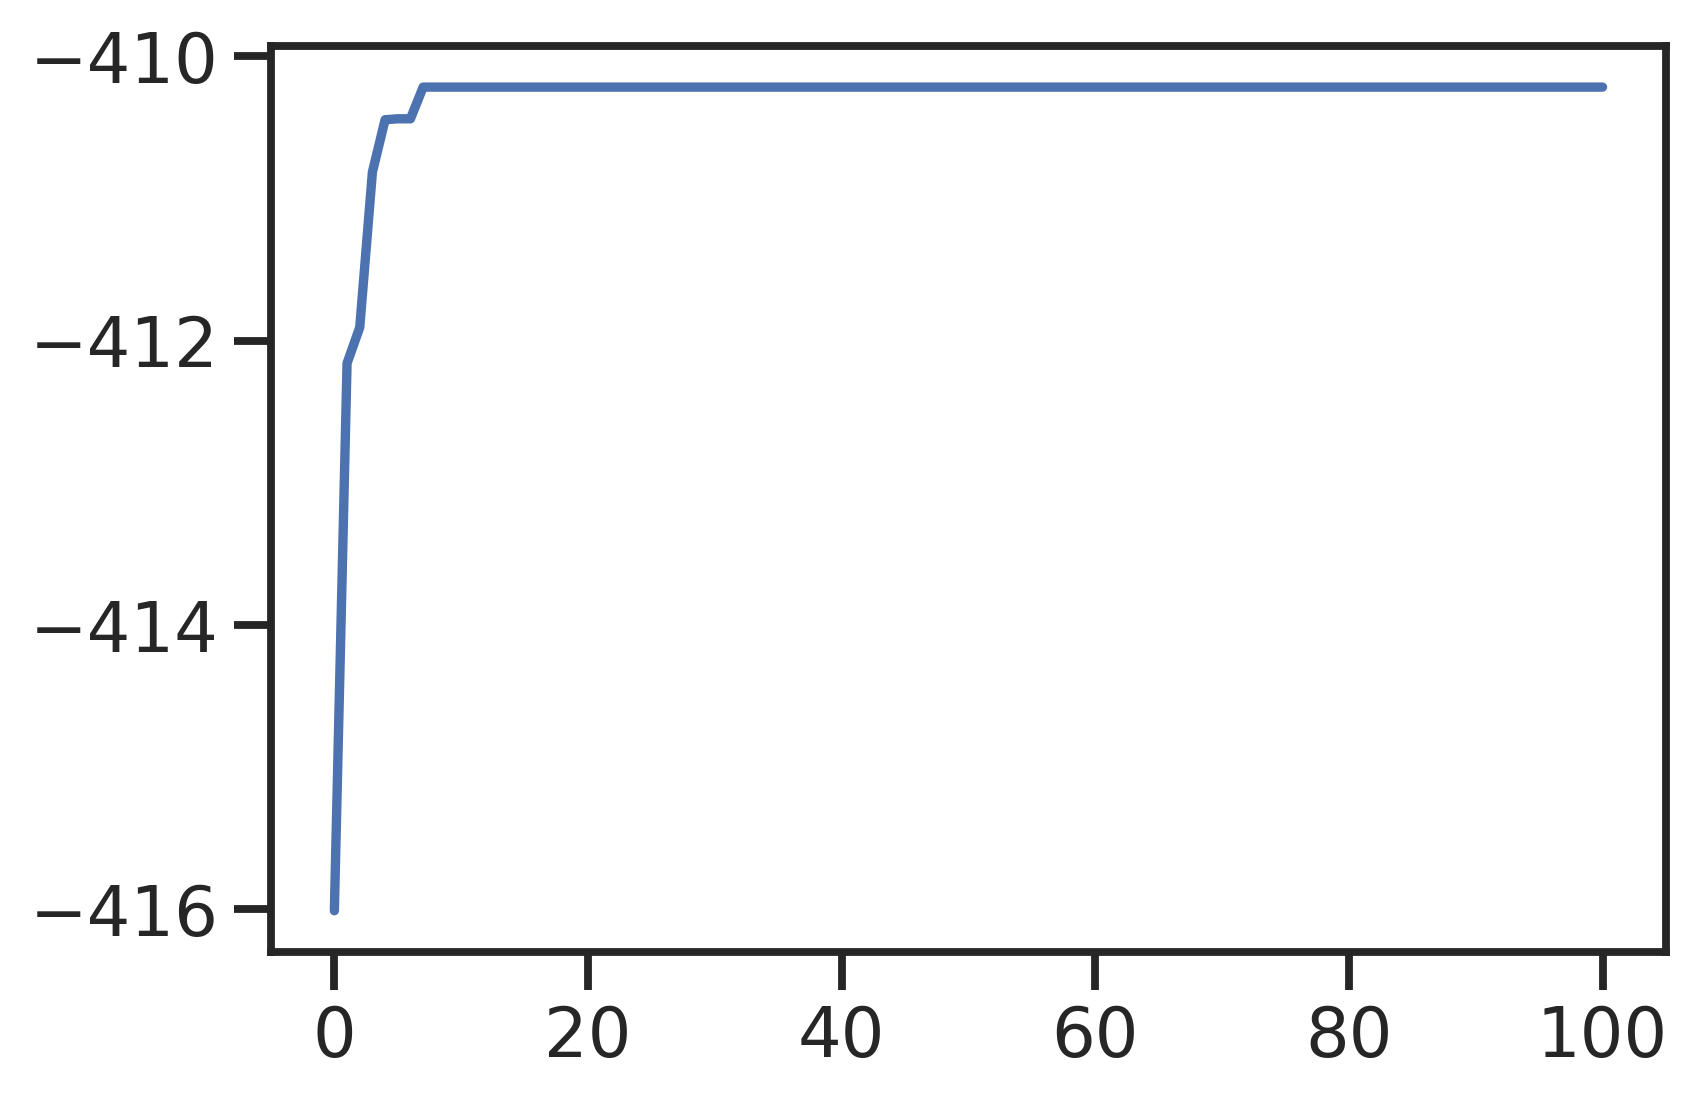

In [39]:
plt.plot(gao.best_fitness_per_generation)

In [40]:
AIC_ps = 2*len(fit_parms) + fit_cost
AIC_ps

414.217089180471

In [41]:
fragments = particle_split(sample_sizes, fit_parms[0], int(fit_parms[1]))
frag_freq = fragment_frequency(fragments)

(0, 25)

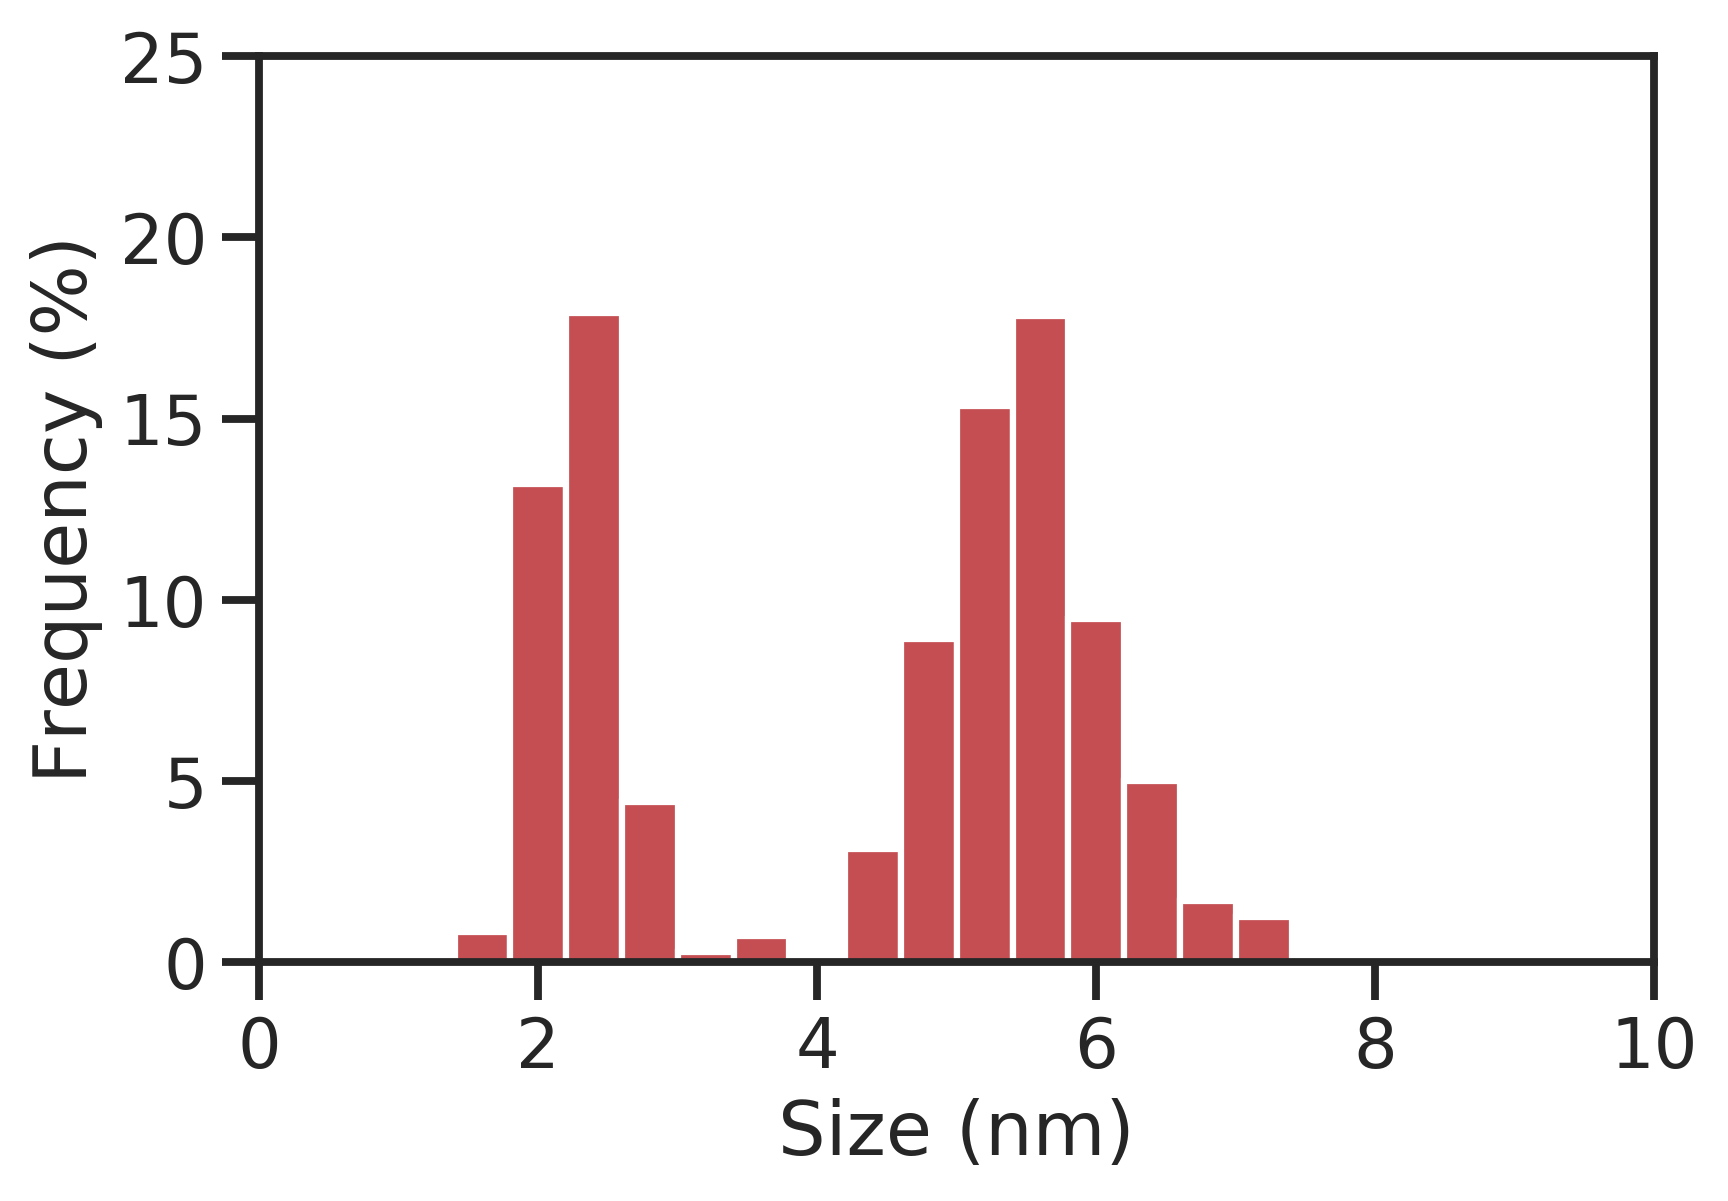

In [42]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,25))

In [43]:
np.savetxt('5nm_nlsfit_frequency_ps.txt', frag_freq)

Text(1, 22, 'SSE=410')

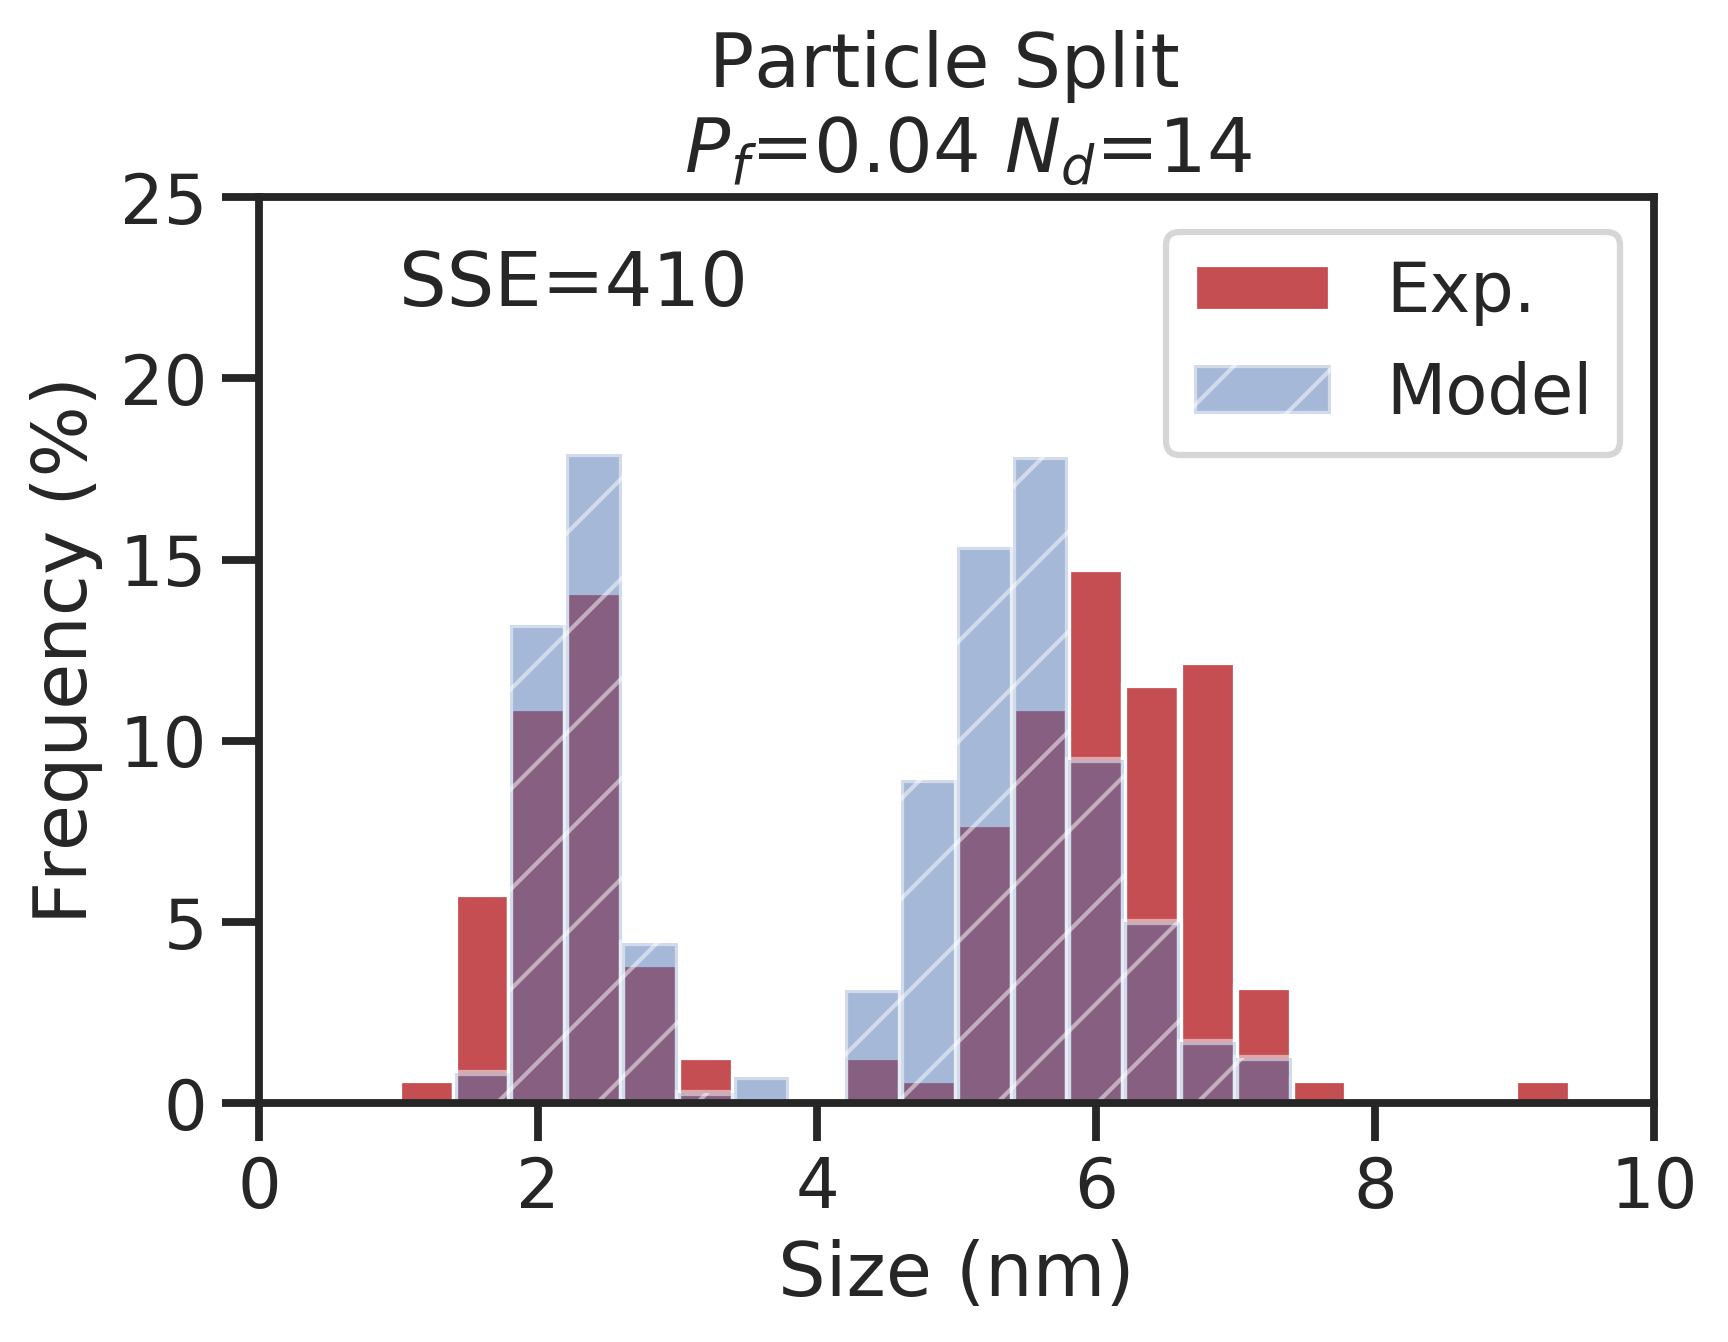

In [44]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))
plt.title("Particle Split \n $P_f$={:.2f} $N_d$={}".format(fit_parms[0], int(fit_parms[1])))
plt.text(1,22, "SSE={:.0f}".format(fit_cost))

## Surface Layer Ablation, Unequal - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [ ]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [ ]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

In [ ]:
#nrepeats = 3
# Set the active point population size
population_size = 1000
#fit_parms_rep = list()
#fit_cost_rep = list()
#for rep in range(nrepeats):
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation_unequal, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)
#    fit_parms_rep.append(fit_parms)
#    fit_cost_rep.append(fit_cost)
#fit_parms_rep = np.array(fit_parms_rep)
#fit_cost_rep = np.array(fit_cost_rep)
#fit_parms = fit_parms_rep.mean(axis=0)
#fit_parms_err = fit_parms_rep.std(axis=0)/np.sqrt(nrepeats)
#fit_cost = fit_cost_rep.mean()
#print(fit_parms, fit_parms_err, fit_cost)

In [ ]:
plt.plot(gao.best_fitness_per_generation)

In [ ]:
AIC_sa_ue = 2*len(fit_parms) + fit_cost
AIC_sa_ue

In [ ]:
fragments = surface_ablation_unequal(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

In [ ]:
#plt.hist(centers, bins=edges, weights=frag_freq, color='r')
#plt.xlim((0,10))
#plt.ylabel("Frequency (%)")
#plt.xlabel("Size (nm)")
#plt.ylim((0,25))

In [ ]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))
plt.title("Surface Ablation \n $P_f$={:.2f} $f_t$={:.2f} $N_d$={}".format(fit_parms[0], fit_parms[1], int(fit_parms[2])))
plt.text(1,22, "SSE={:.0f}".format(fit_cost))

----

# 15 nm

In [45]:
# Load the data
dist = pd.read_csv('15nm_distribution.csv')
dist.head()

,size,initial,laser
0,2,0.00000,2.30769
1,4,0.00000,36.92308
2,6,0.13661,17.69231
3,8,0.13661,0.76923
4,10,0.27322,0.00000


In [46]:
# Get the histogram bin centers
centers = dist['size'].to_numpy()
centers

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24])

In [47]:
# Histogram bin width
bw = centers[1] - centers[0]
bw

2

In [48]:
# Create the corresponding edges for the histogram
edges = np.linspace(centers[0] - 0.5*bw, centers[-1] + 0.5*bw, len(centers)+1, endpoint=True)
edges

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.])

In [49]:
# Create a distribution object from the histogrammed frequencies.
rv_initial = rv_histogram((dist['initial'].to_numpy(), edges))
rv_initial

In [50]:
sample_sizes = rv_initial.rvs(size=10000, random_state=14983)
sample_sizes[:10]

array([17.14193827, 16.97853438, 15.96054516, 17.744099  , 16.69100088,
       18.88555678, 15.96270644, 16.53133495, 16.64004434, 17.88322272])

[0.   0.   0.16 0.14 0.33]


(0, 60)

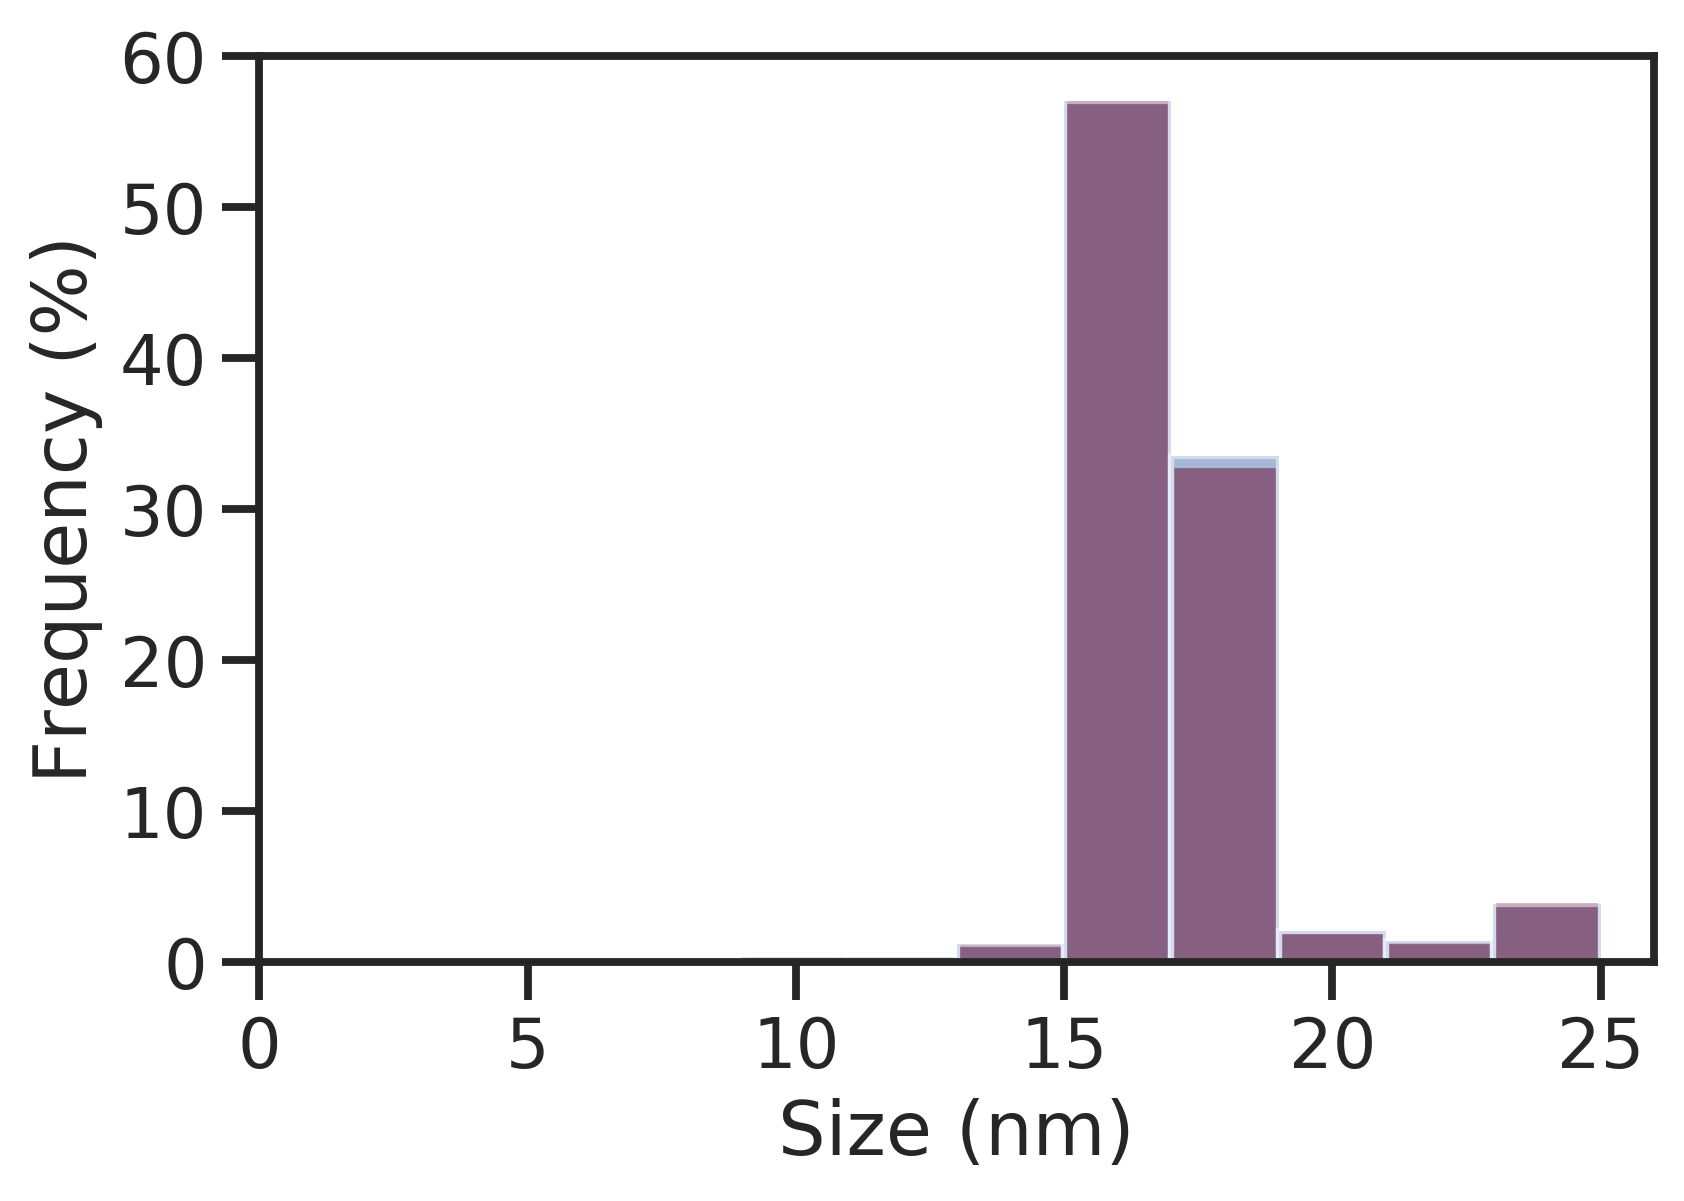

In [51]:
counts, _edges = np.histogram(sample_sizes, bins=edges)

freq = 100 * counts / len(sample_sizes)
print(freq[:5])
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.hist(centers, bins=edges, weights=freq, color='b', alpha=0.5)
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

(0, 60)

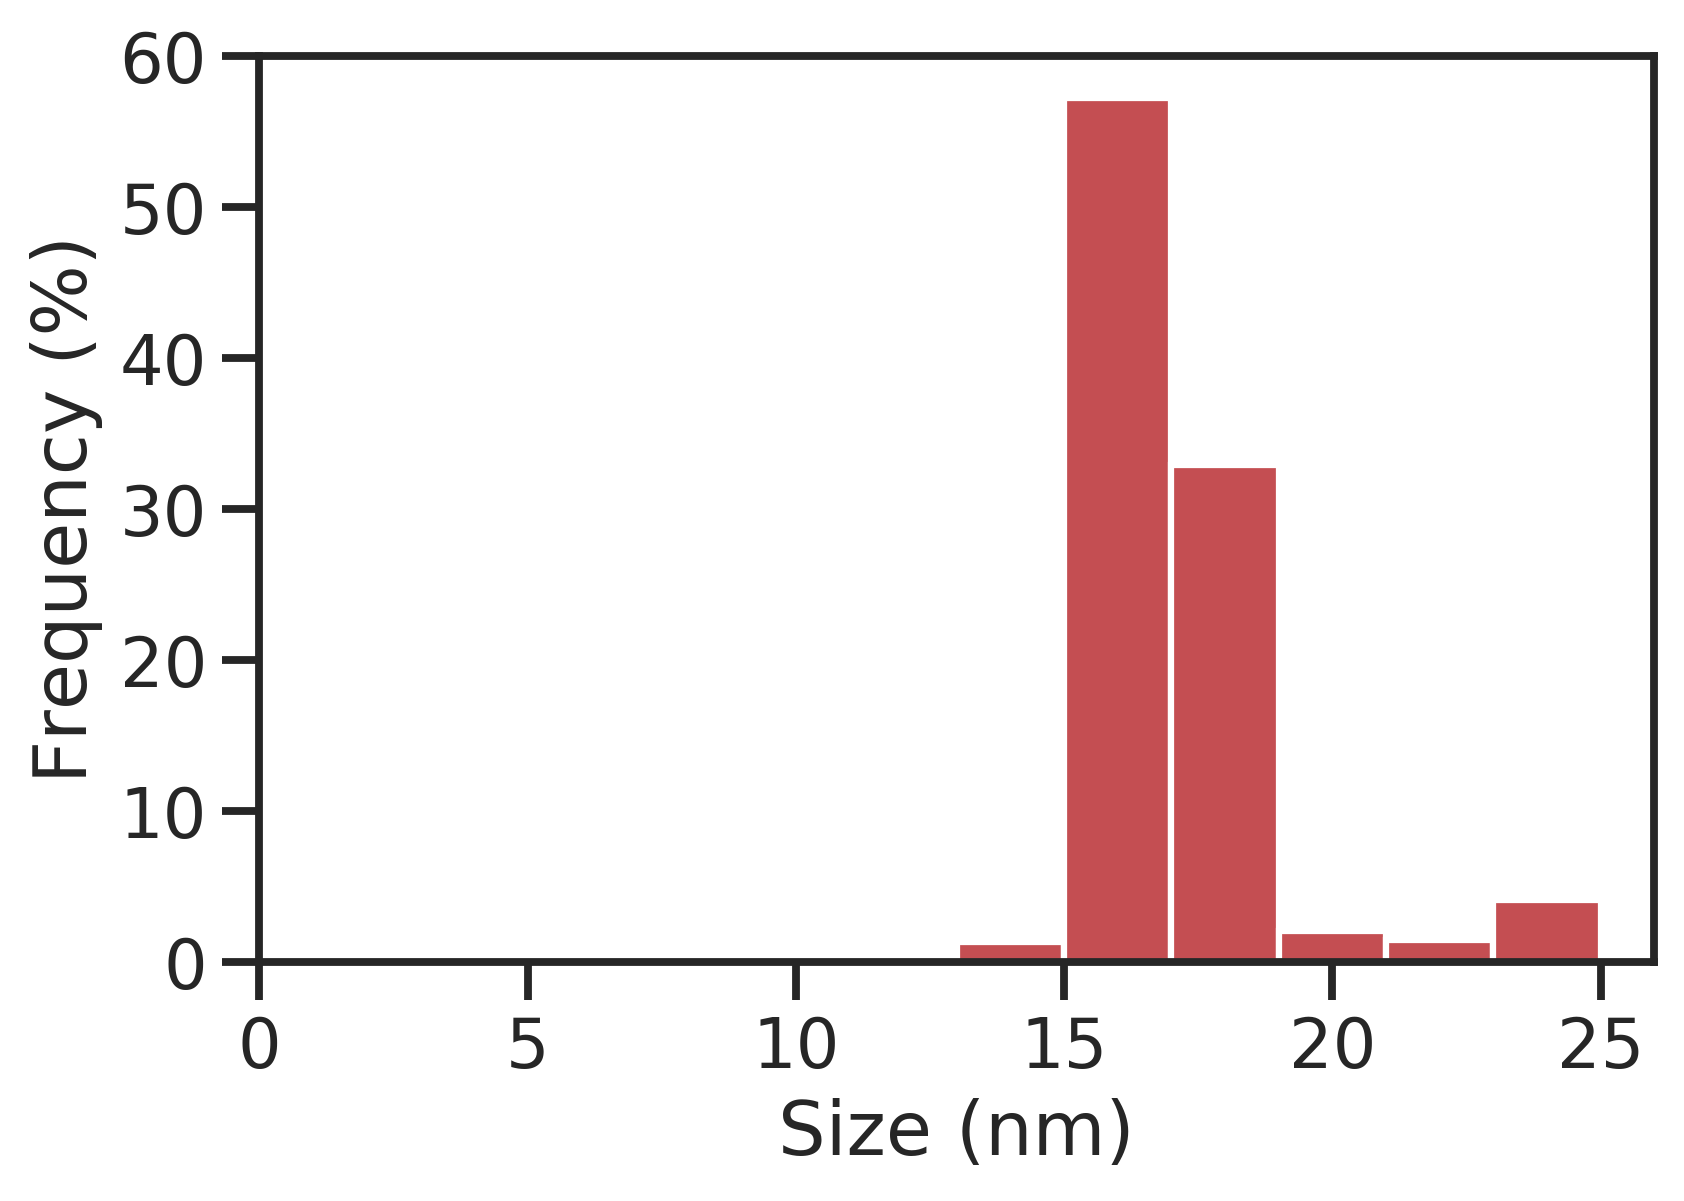

In [52]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

## Surface Layer Ablation - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [53]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [54]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

In [70]:
#nrepeats = 3
# Set the active point population size
population_size = 1000
#fit_parms_rep = list()
#fit_cost_rep = list()
#for rep in range(nrepeats):
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)
#    fit_parms_rep.append(fit_parms)
#    fit_cost_rep.append(fit_cost)
#fit_parms_rep = np.array(fit_parms_rep)
#fit_cost_rep = np.array(fit_cost_rep)
#fit_parms = fit_parms_rep.mean(axis=0)
#fit_parms_err = fit_parms_rep.std(axis=0)/np.sqrt(nrepeats)
#fit_cost = fit_cost_rep.mean()
#print(fit_parms, fit_parms_err, fit_cost)

Generations: 100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


[ 0.15153078  0.09984611 11.24116497] 231.4935335327392


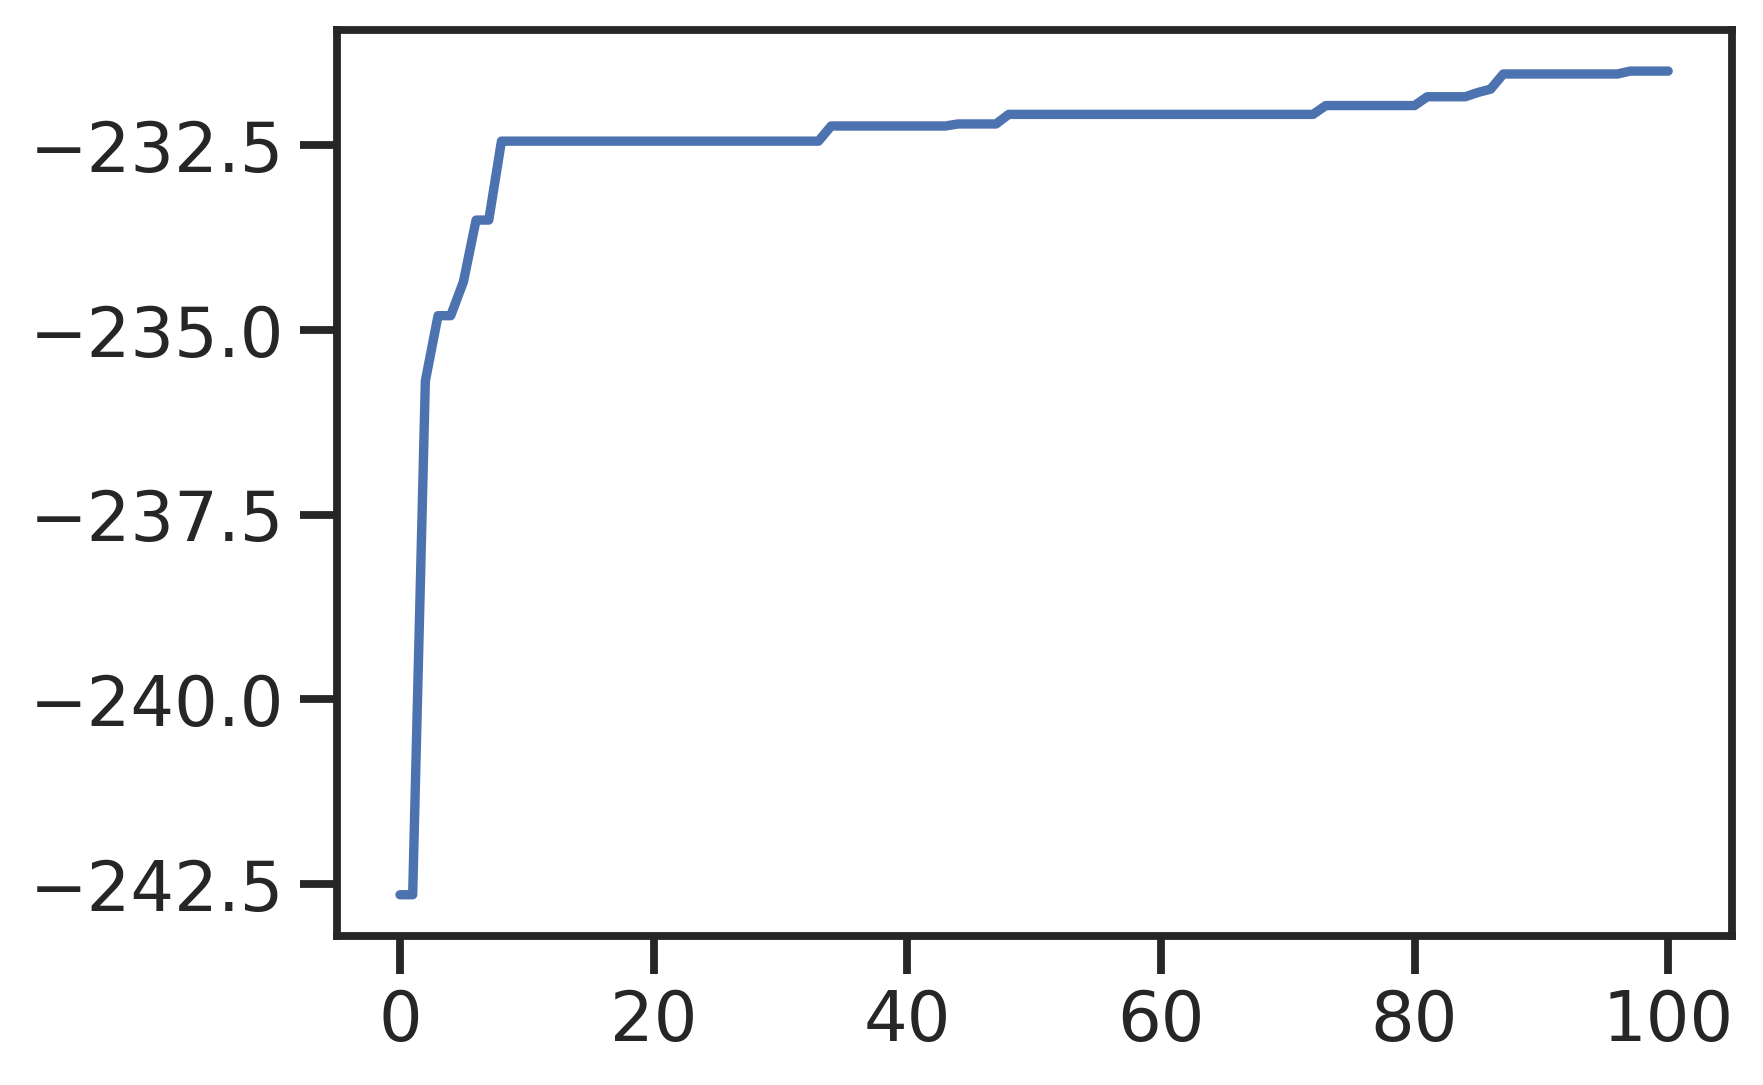

In [71]:
plt.plot(gao.best_fitness_per_generation)

In [72]:
AIC_sa = 2*len(fit_parms) + fit_cost
AIC_sa

237.4935335327392

In [73]:
fragments = surface_ablation(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

(0, 60)

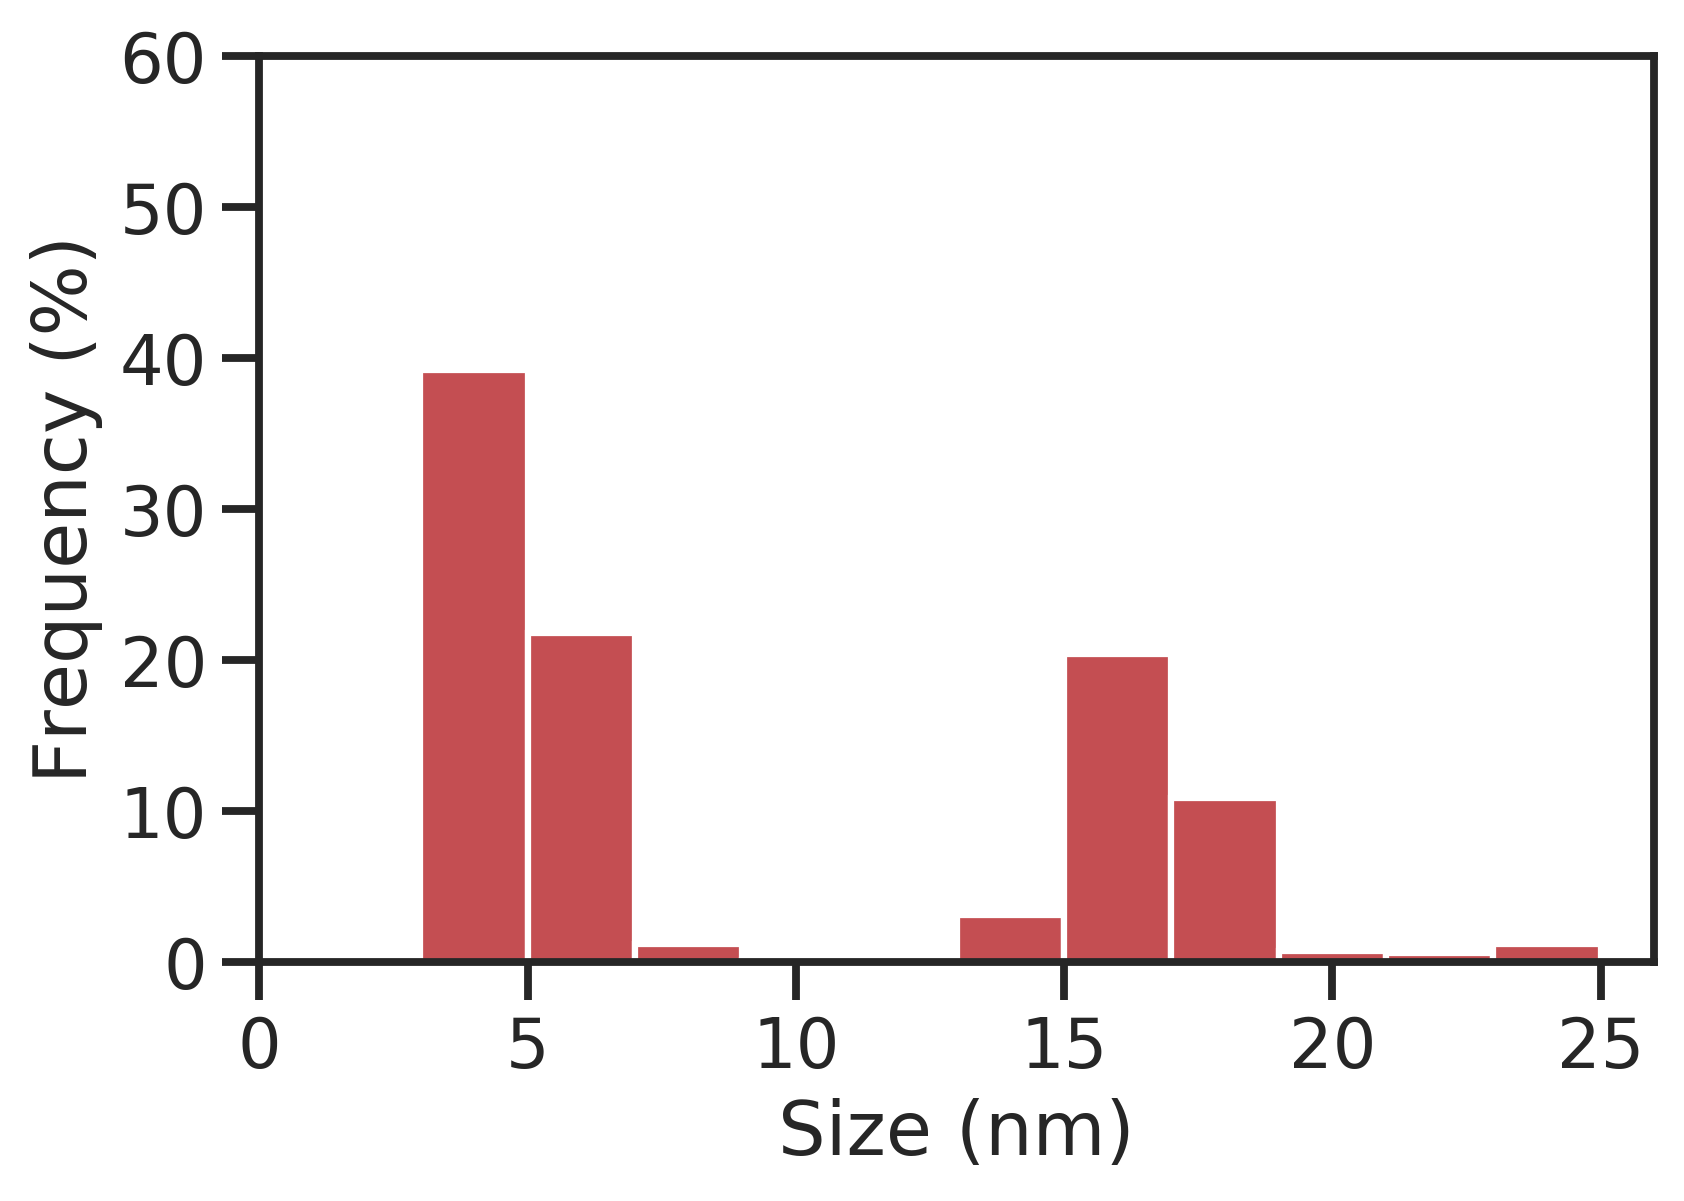

In [74]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

In [75]:
np.savetxt('15nm_nlsfit_centers.txt', centers)
np.savetxt('15nm_nlsfit_edges.txt', edges)
np.savetxt('15nm_nlsfit_frequency_sa.txt', frag_freq)

In [76]:
fit_parms

array([ 0.15153078,  0.09984611, 11.24116497])

Text(3, 52, 'SSE=231')

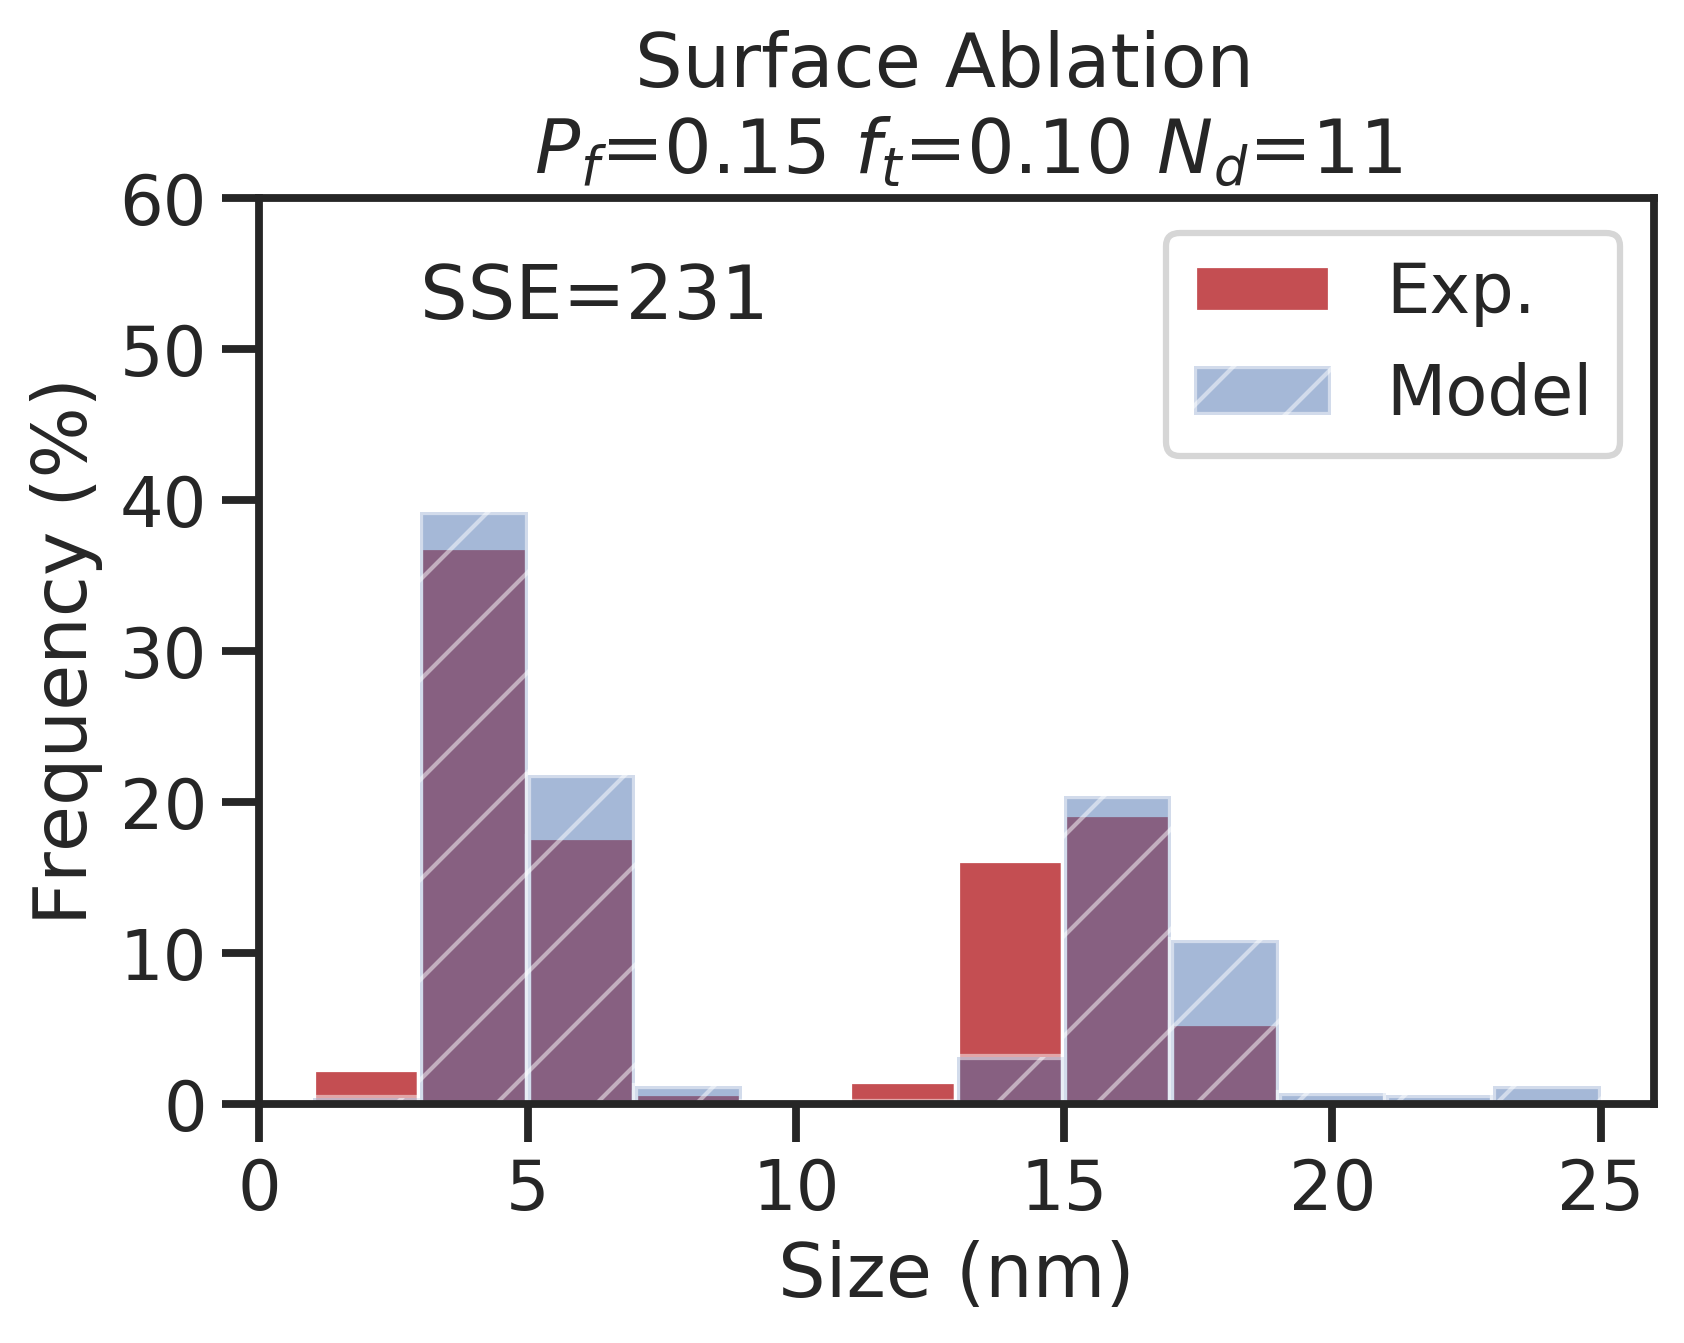

In [77]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,60))
#plt.suptitle("Surface Ablation")
plt.title("Surface Ablation \n $P_f$={:.2f} $f_t$={:.2f} $N_d$={}".format(fit_parms[0], fit_parms[1], int(fit_parms[2])))
plt.text(3,52, "SSE={:.0f}".format(fit_cost))

## Particle Split - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [63]:
# Set the active point population size
population_size = 1000
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_ps, fitness_particle_split, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)

Generations: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


[3.92466037e-02 4.14509781e+01] 333.12289257888705


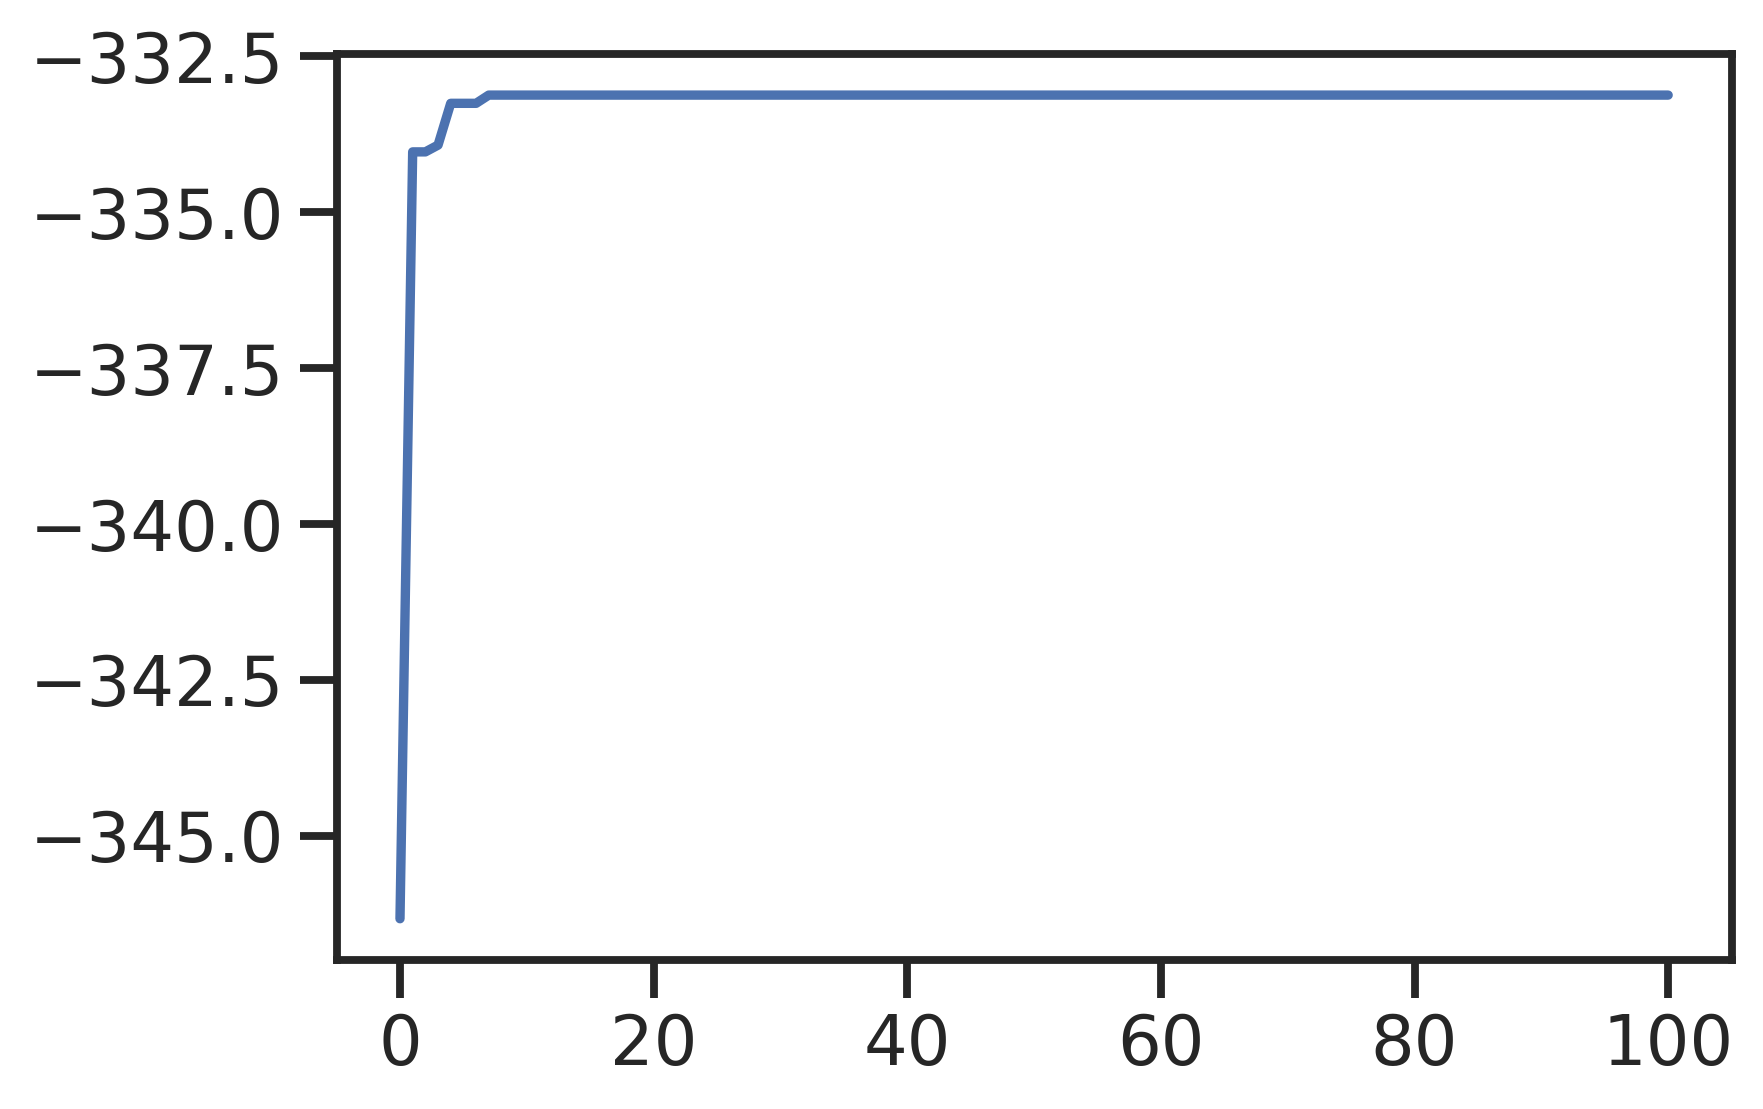

In [64]:
plt.plot(gao.best_fitness_per_generation)

In [65]:
AIC_ps = 2*len(fit_parms) + fit_cost
AIC_ps

337.12289257888705

In [66]:
fragments = particle_split(sample_sizes, fit_parms[0], int(fit_parms[1]))
frag_freq = fragment_frequency(fragments)

(0, 60)

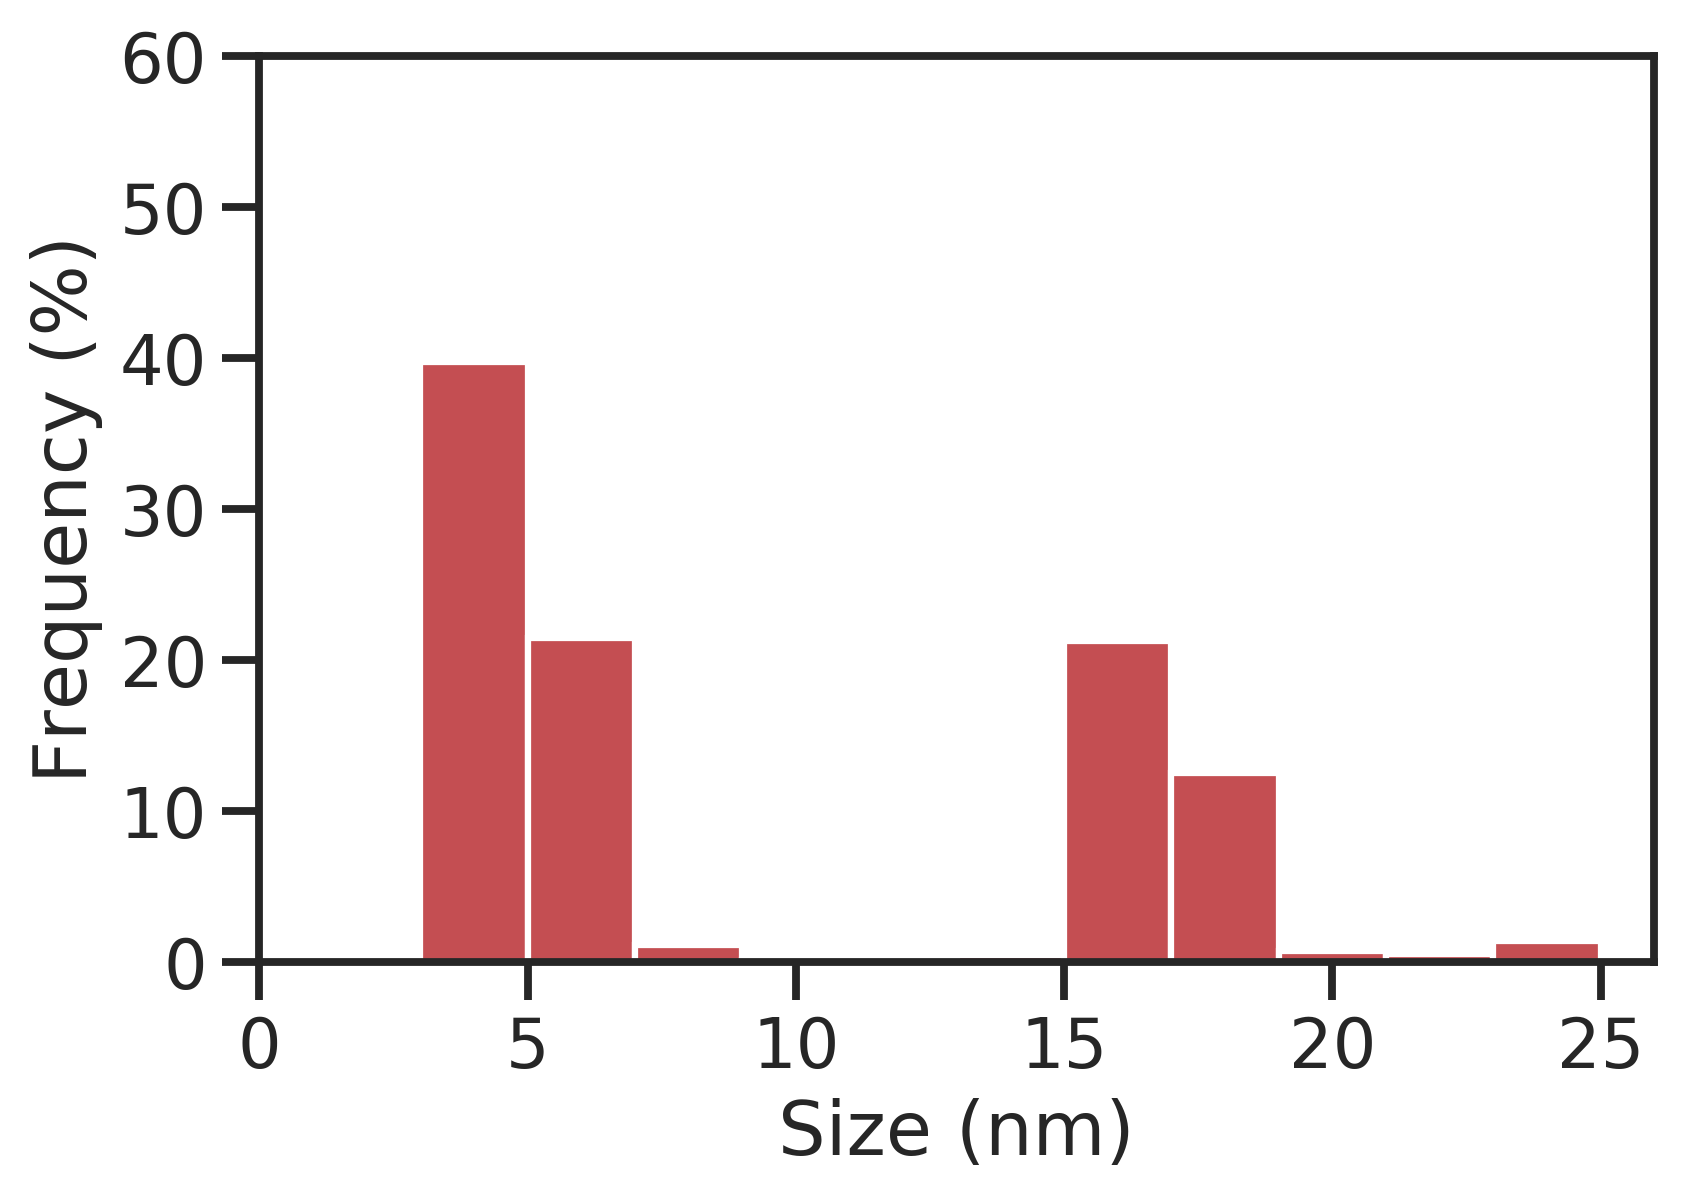

In [67]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

In [68]:
np.savetxt('15nm_nlsfit_frequency_ps.txt', frag_freq)

Text(3, 52, 'SSE=333')

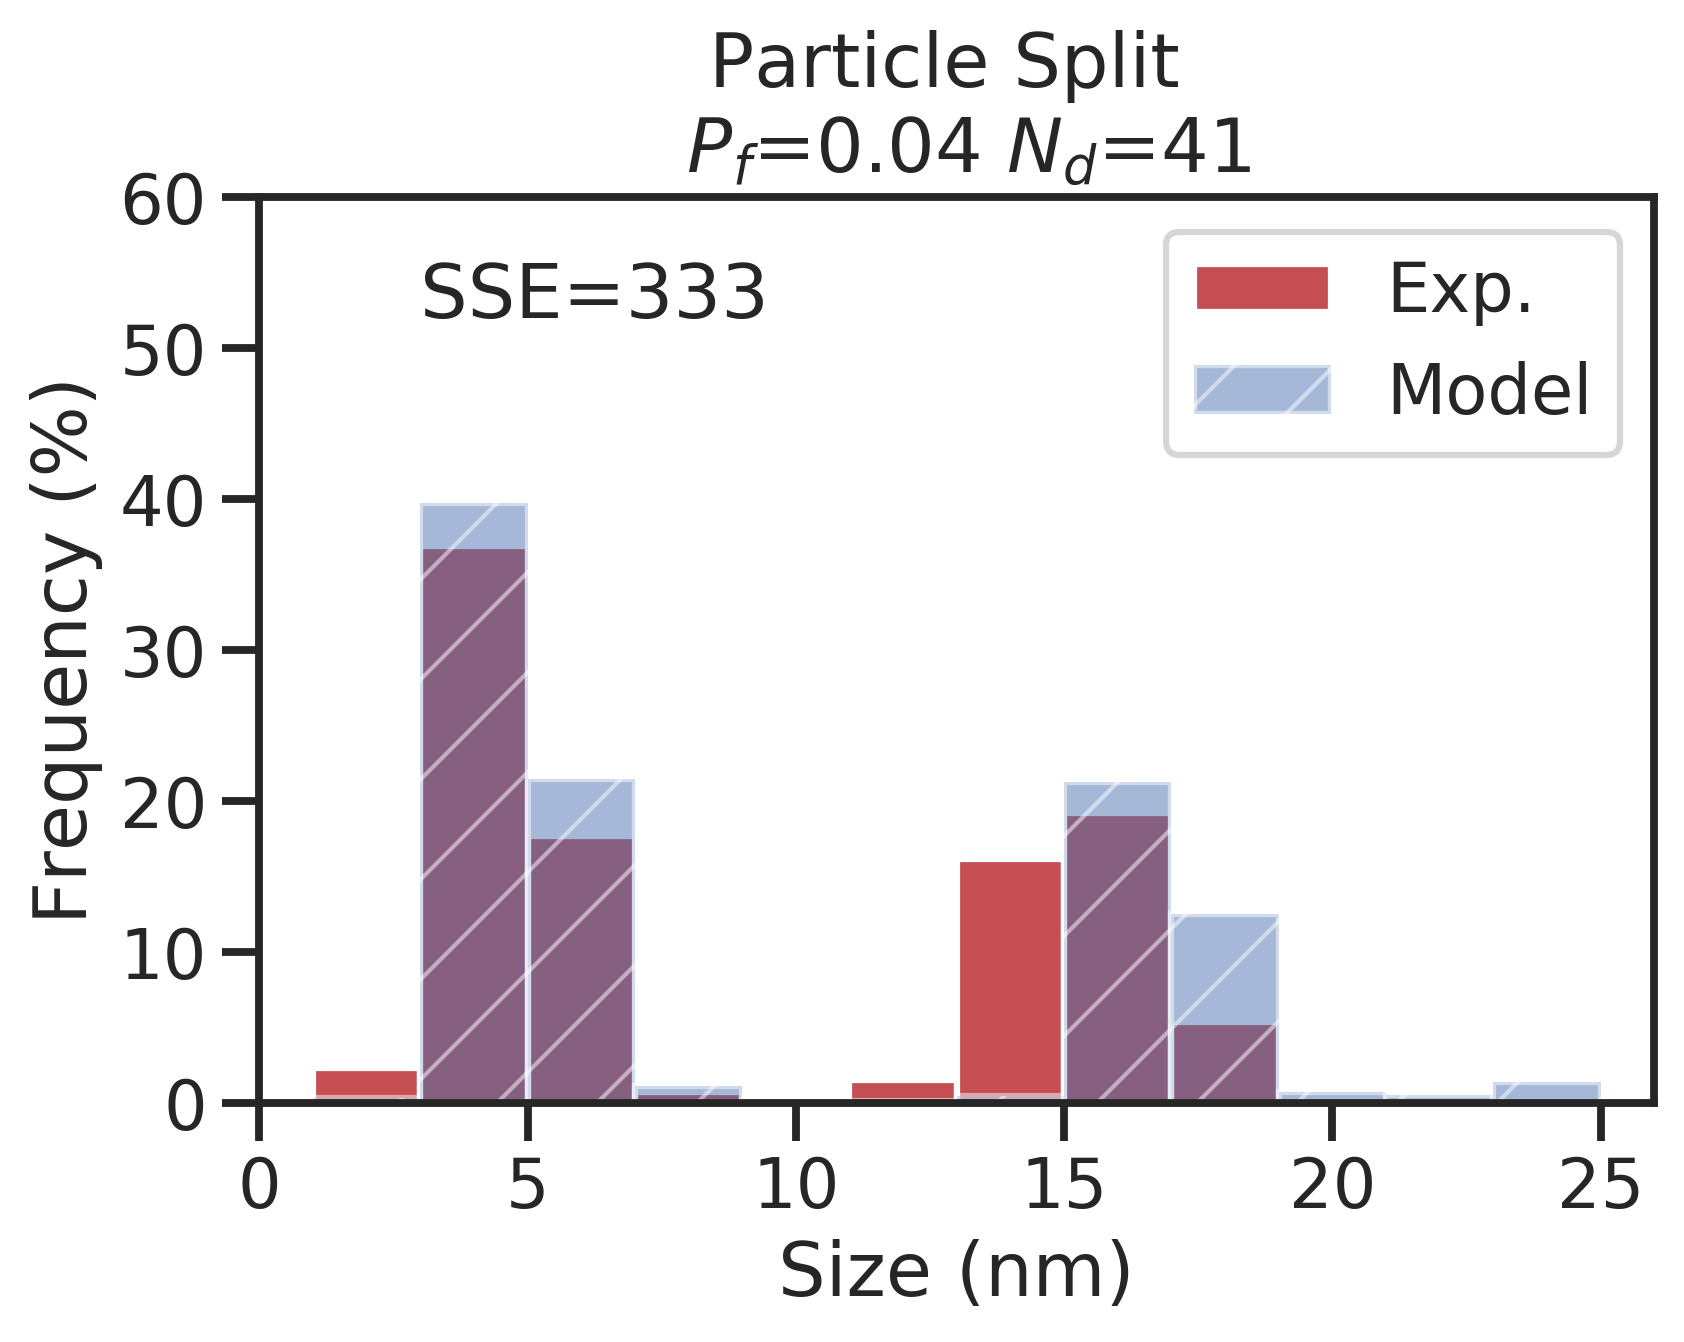

In [69]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,60))
plt.title("Particle Split \n $P_f$={:.2f} $N_d$={}".format(fit_parms[0], int(fit_parms[1])))
plt.text(3,52, "SSE={:.0f}".format(fit_cost))

# 100 nm

In [78]:
# Load the data
dist = pd.read_csv('100nm_distribution.csv')
dist.head()

,size,initial,laser
0,5,0.0,0.00000
1,10,0.0,33.96226
2,15,0.0,22.64151
3,20,0.0,7.54717
4,25,0.0,6.60377


In [79]:
# Get the histogram bin centers
centers = dist['size'].to_numpy()
centers

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130])

In [80]:
# Histogram bin width
bw = centers[1] - centers[0]
bw

5

In [81]:
# Create the corresponding edges for the histogram
edges = np.linspace(centers[0] - 0.5*bw, centers[-1] + 0.5*bw, len(centers)+1, endpoint=True)
edges

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5])

In [82]:
# Create a distribution object from the histogrammed frequencies.
rv_initial = rv_histogram((dist['initial'].to_numpy(), edges))
rv_initial

In [83]:
sample_sizes = rv_initial.rvs(size=10000, random_state=14983)
sample_sizes[:10]

array([103.33278702, 102.4971695 ,  94.93244976, 106.14136259,
       100.49863177, 115.1719412 ,  94.95100661,  99.38885372,
       100.14445194, 106.79025824])

[0. 0. 0. 0. 0.]


(0, 30)

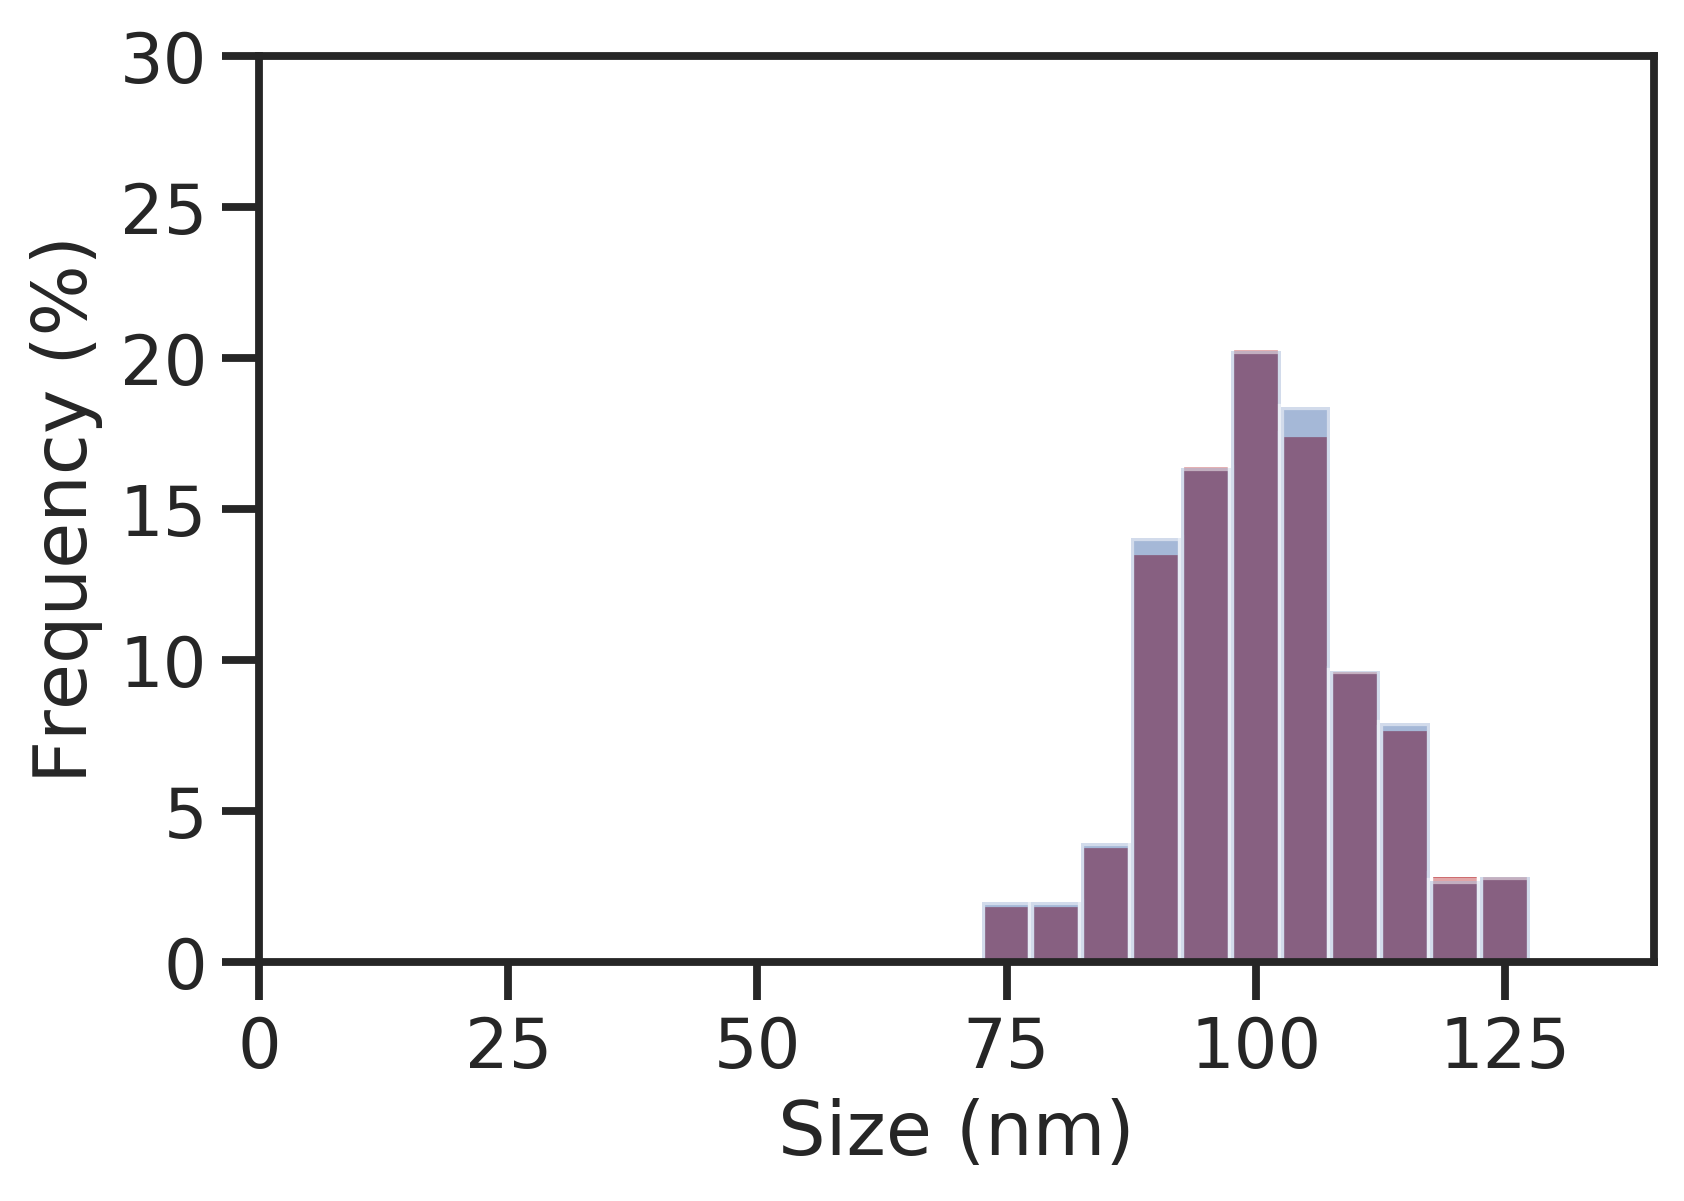

In [84]:
counts, _edges = np.histogram(sample_sizes, bins=edges)

freq = 100 * counts / len(sample_sizes)
print(freq[:5])
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.hist(centers, bins=edges, weights=freq, color='b', alpha=0.5)
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,30))

(0, 50)

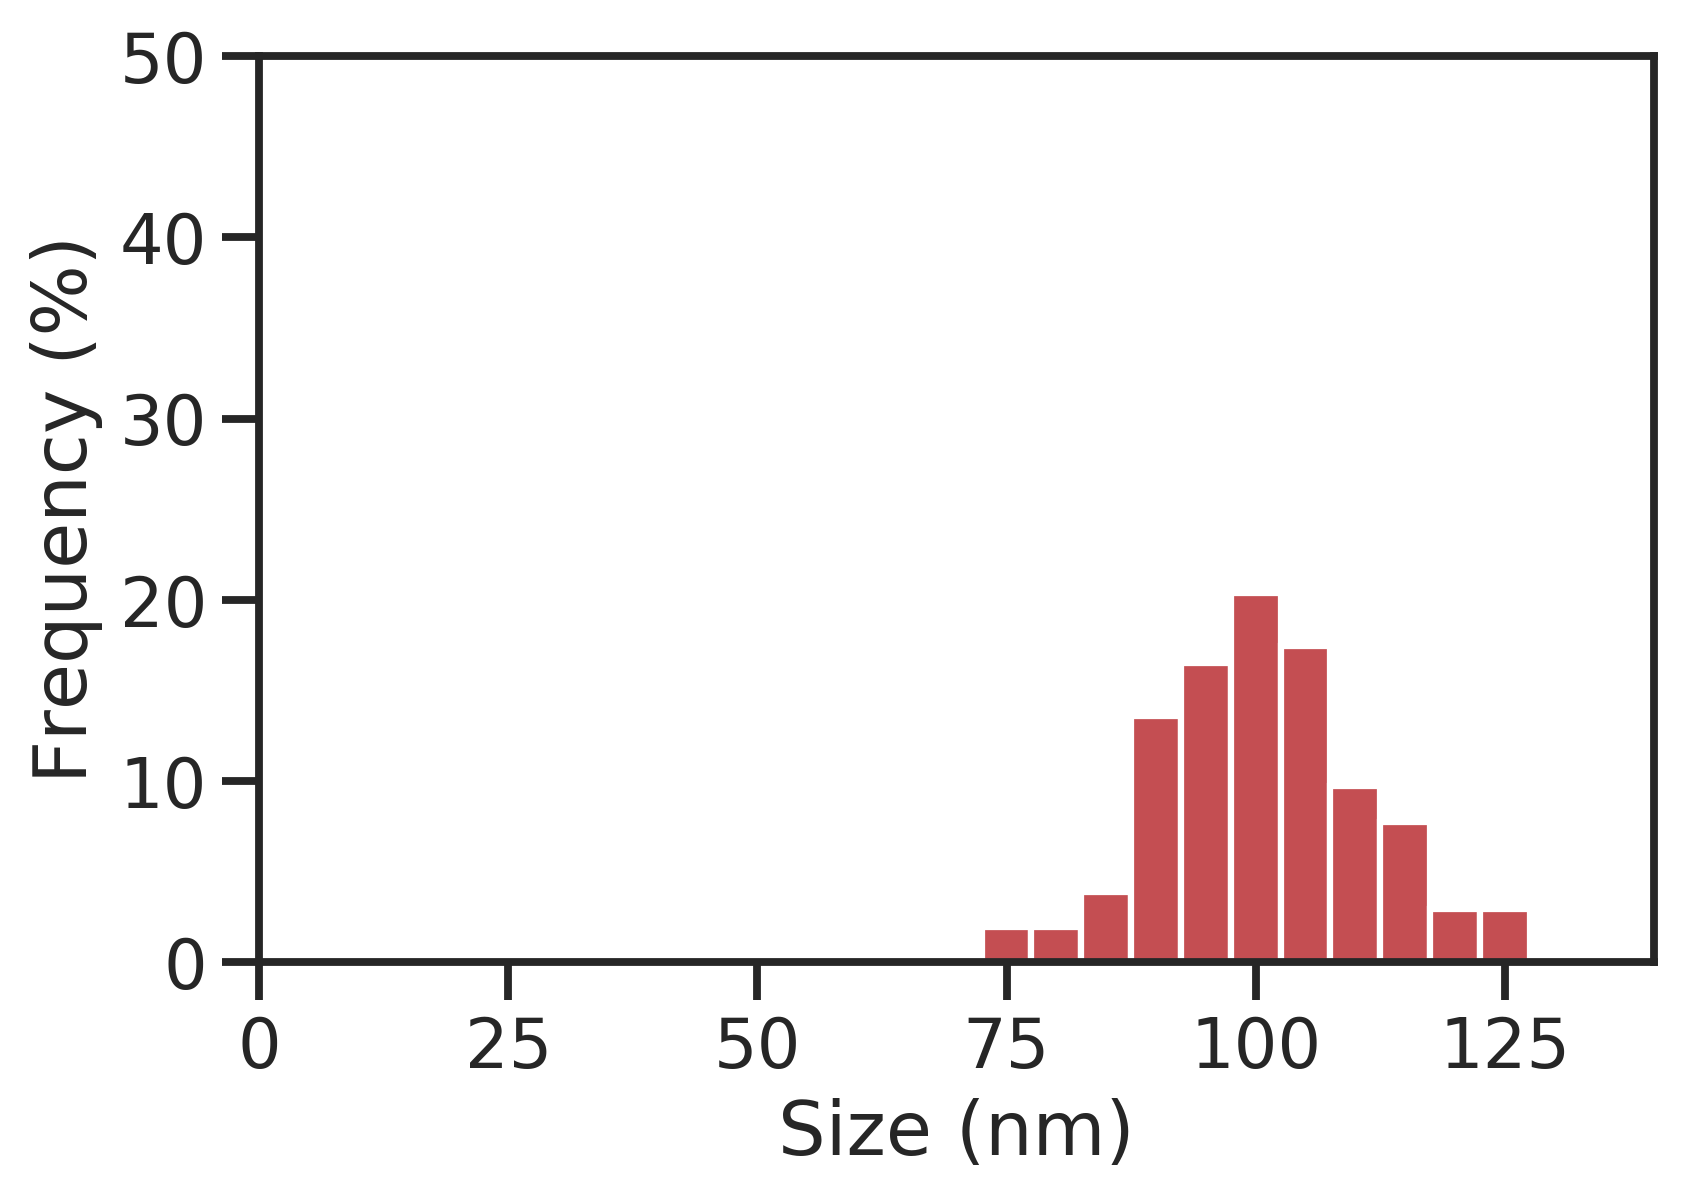

In [85]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,50))

## Surface Layer Ablation - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [129]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [130]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

In [131]:
#nrepeats = 3
# Set the active point population size
population_size = 1000
#fit_parms_rep = list()
#fit_cost_rep = list()
#for rep in range(nrepeats):
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)
#    fit_parms_rep.append(fit_parms)
#    fit_cost_rep.append(fit_cost)
#fit_parms_rep = np.array(fit_parms_rep)
#fit_cost_rep = np.array(fit_cost_rep)
#fit_parms = fit_parms_rep.mean(axis=0)
#fit_parms_err = fit_parms_rep.std(axis=0)/np.sqrt(nrepeats)
#fit_cost = fit_cost_rep.mean()
#print(fit_parms, fit_parms_err, fit_cost)

Generations: 100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


[1.85420571e-02 6.06888698e-02 9.48005521e+01] 378.4304782817354


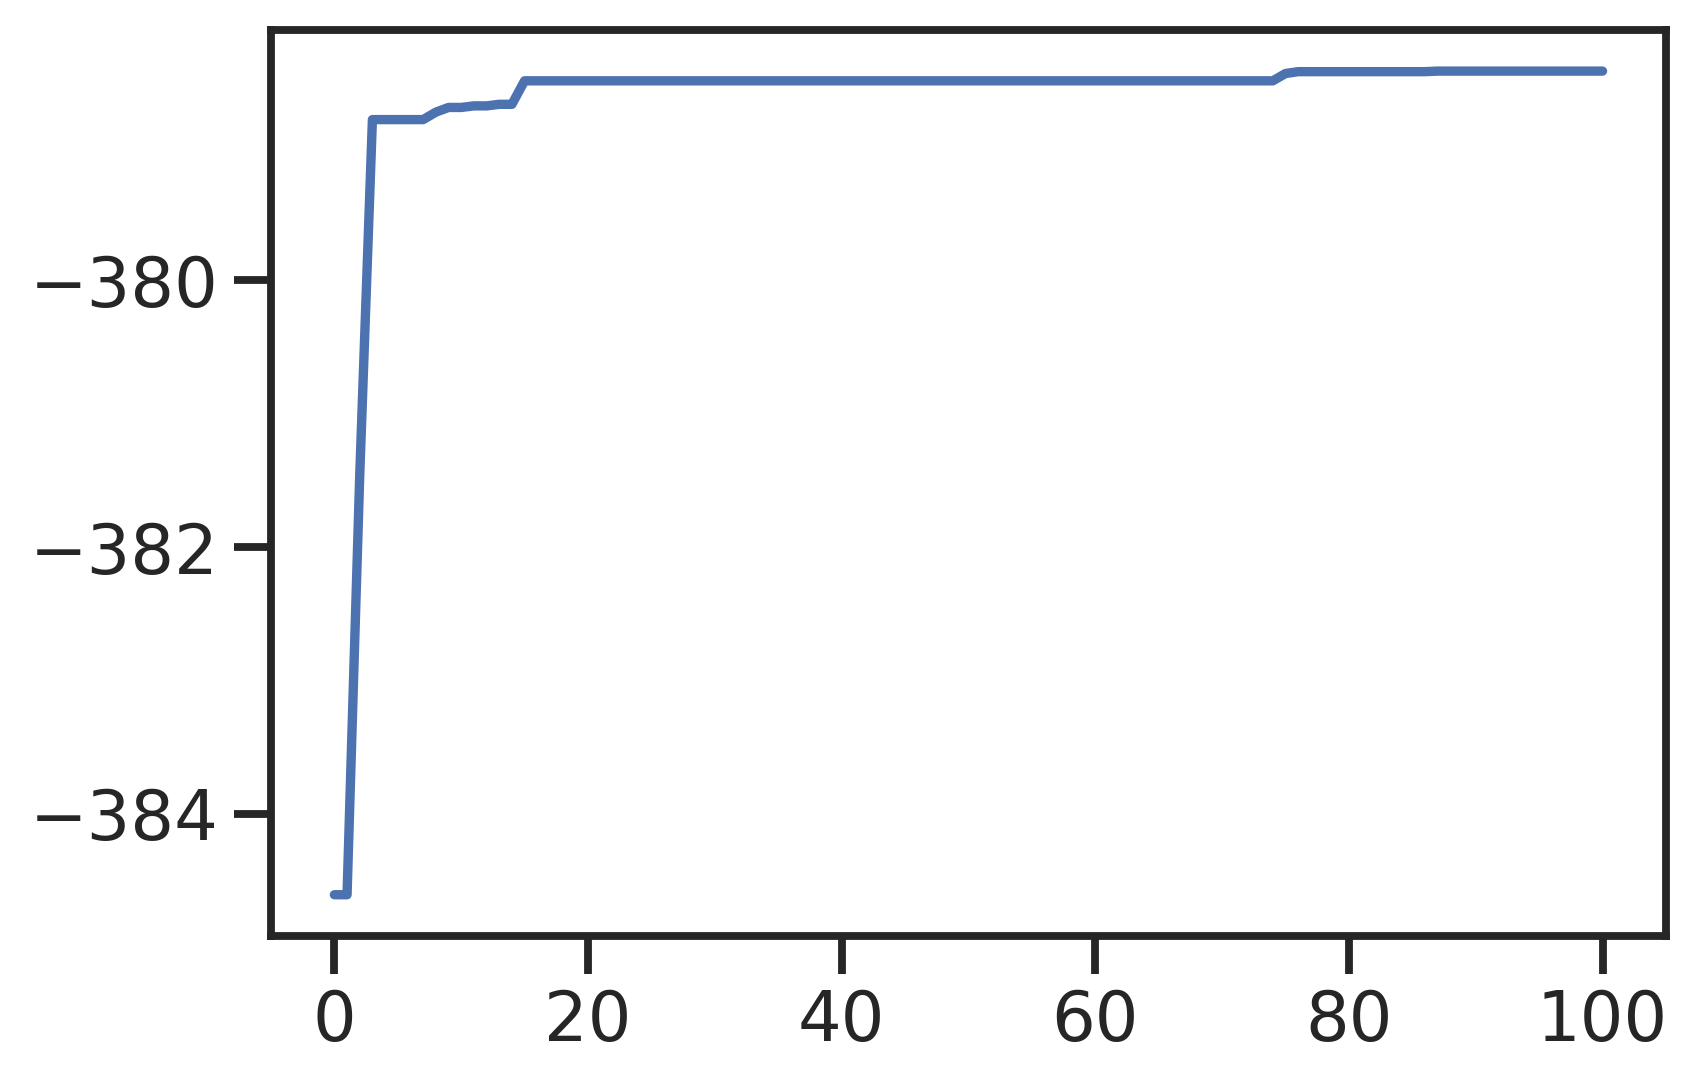

In [132]:
plt.plot(gao.best_fitness_per_generation)

In [133]:
AIC_sa = 2*len(fit_parms) + fit_cost
AIC_sa

384.4304782817354

In [134]:
fragments = surface_ablation(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

(0, 50)

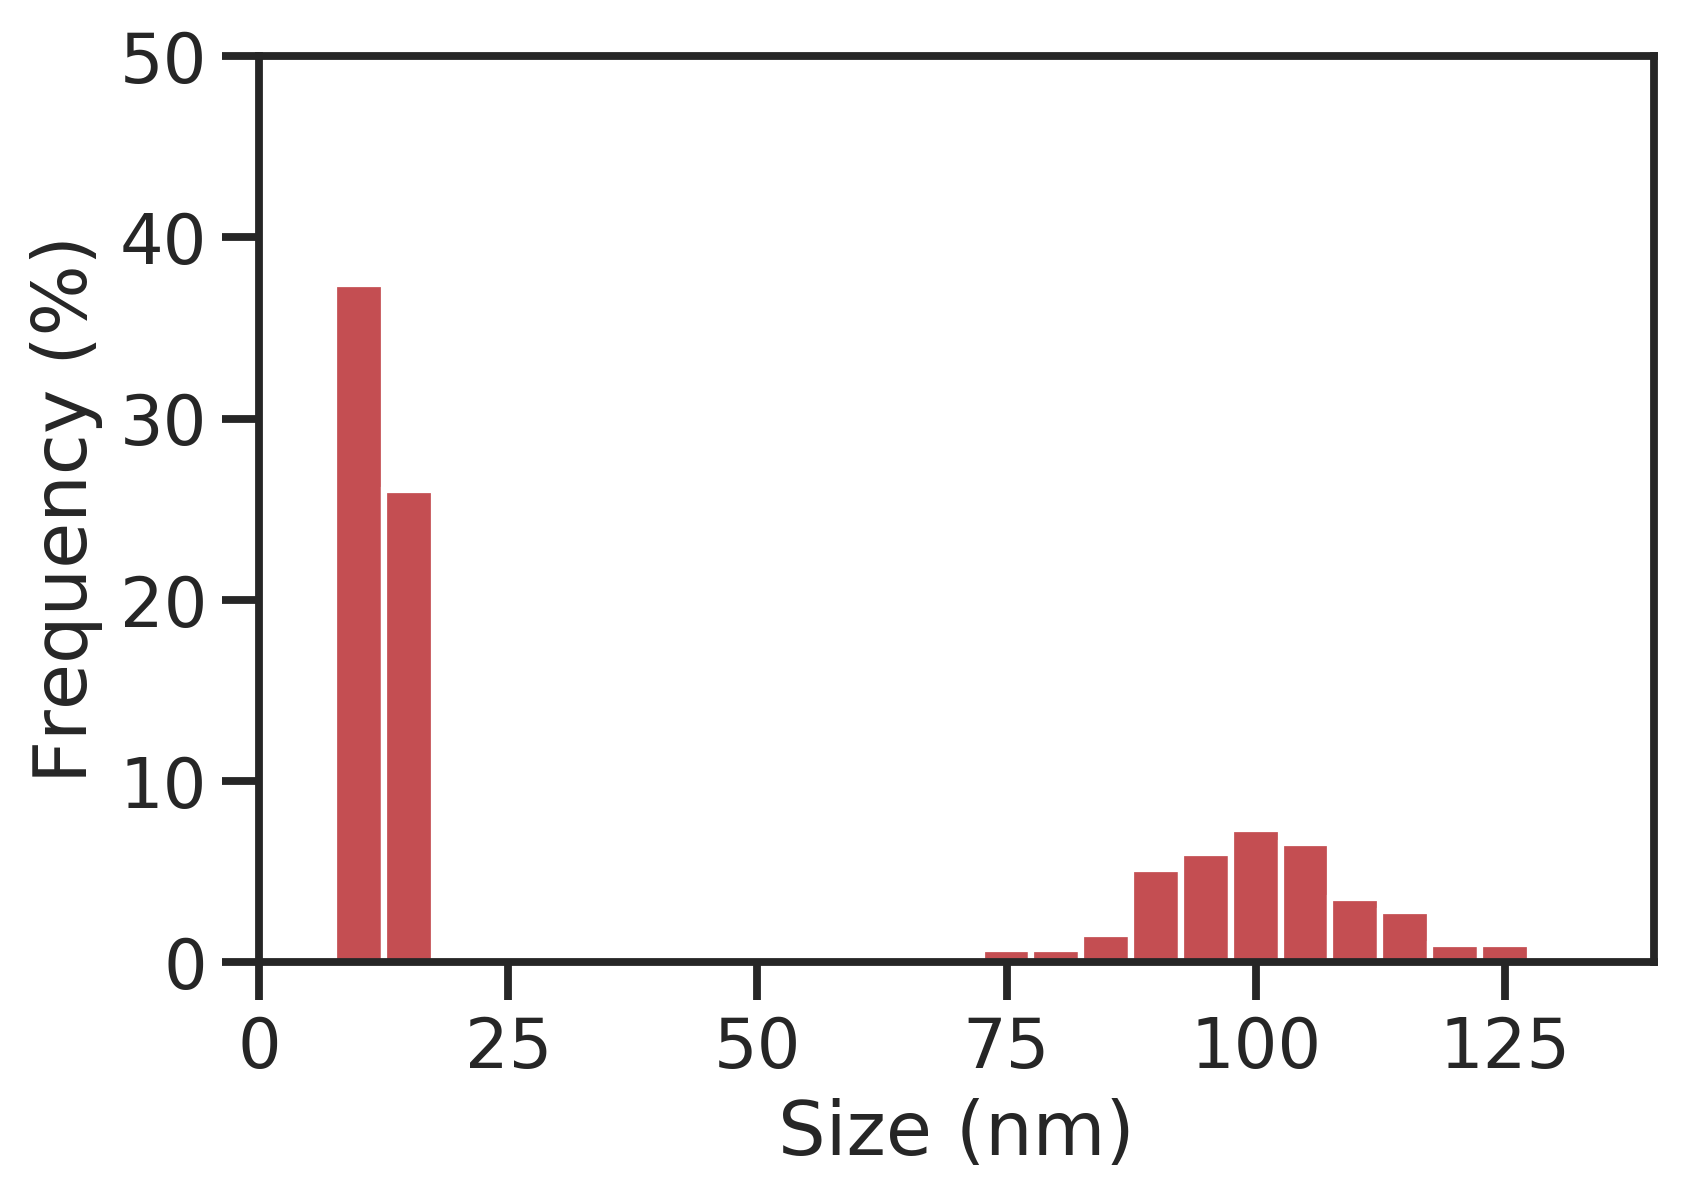

In [135]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,50))

In [136]:
fit_parms

array([1.85420571e-02, 6.06888698e-02, 9.48005521e+01])

In [137]:
np.savetxt('100nm_nlsfit_centers.txt', centers)
np.savetxt('100nm_nlsfit_edges.txt', edges)
np.savetxt('100nm_nlsfit_frequency_sa.txt', frag_freq)

Text(10, 44, 'SSE=378')

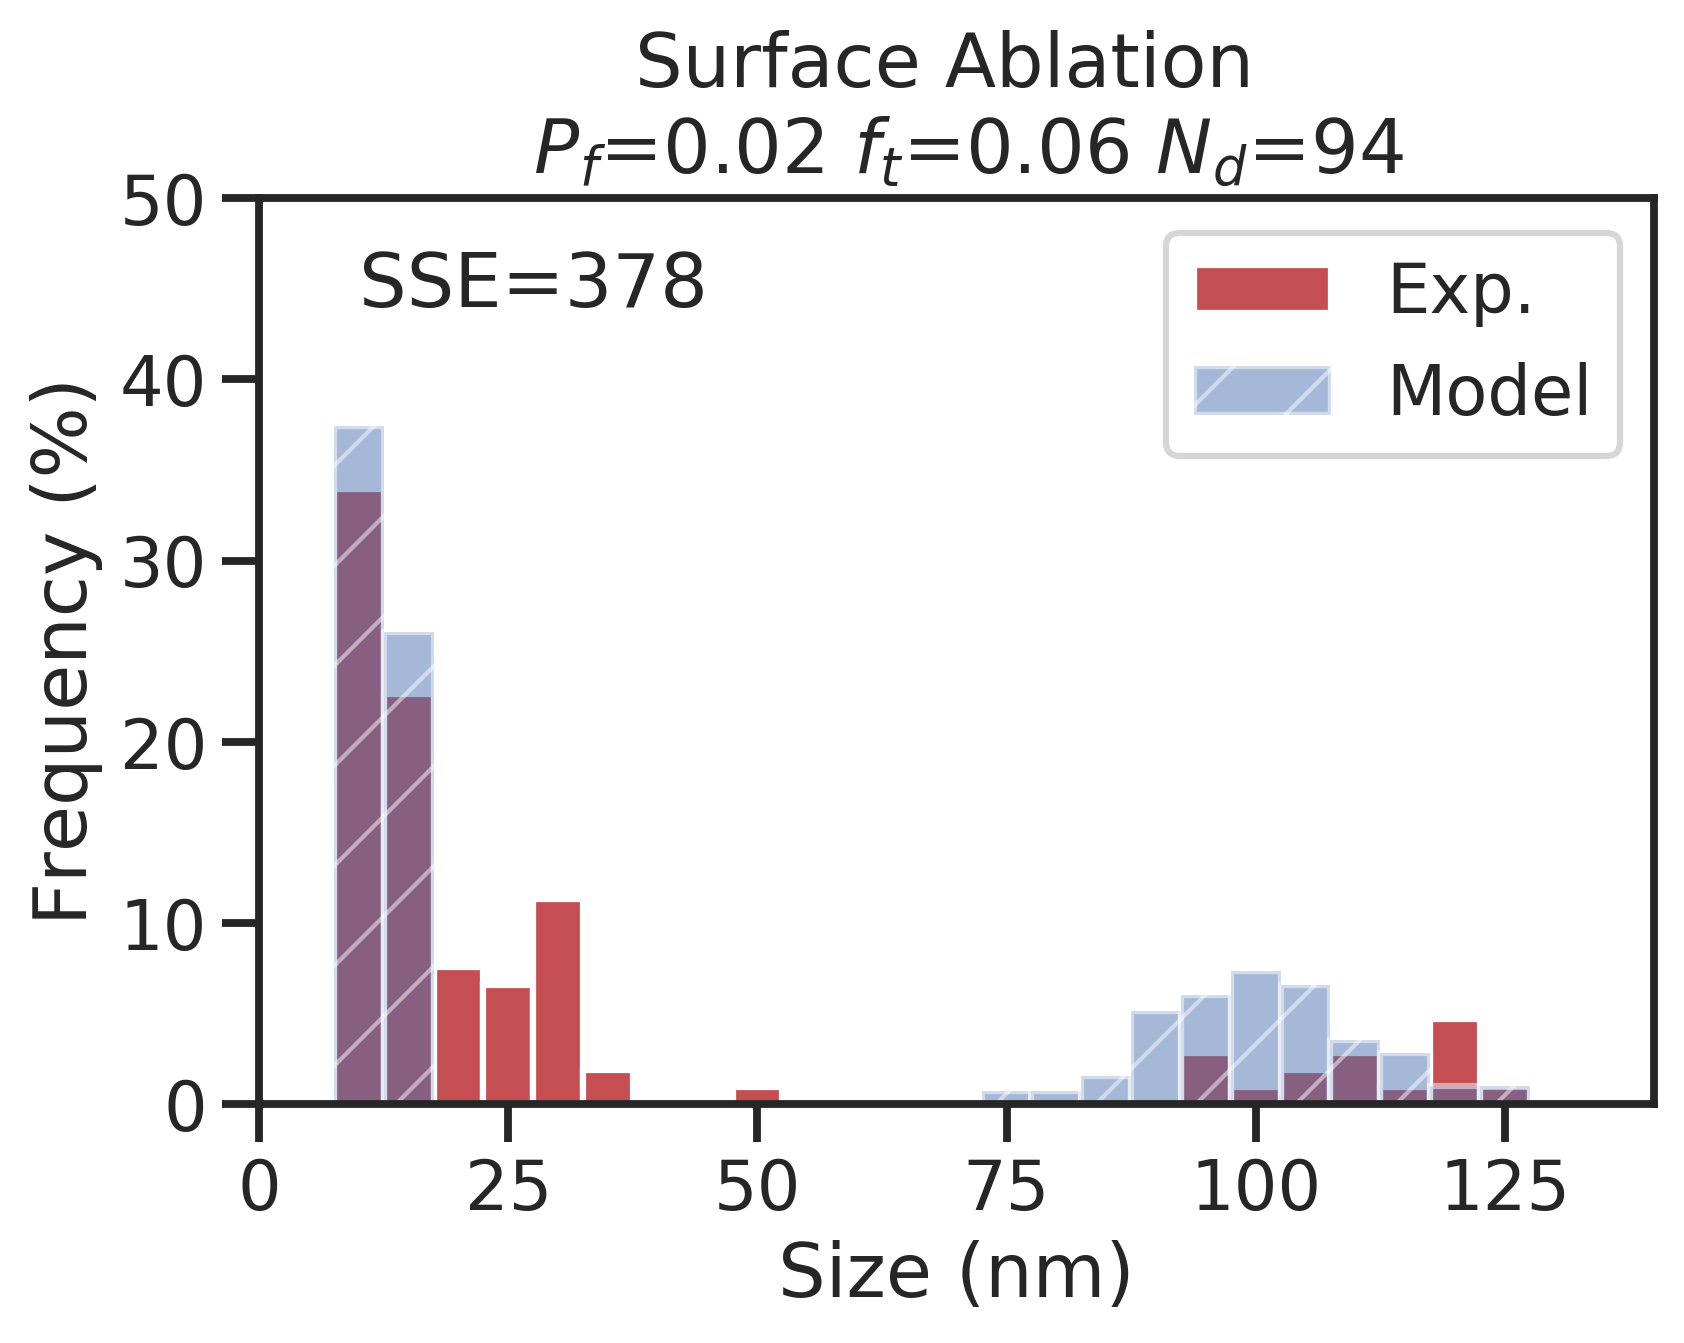

In [138]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,50))
#plt.suptitle("Surface Ablation")
plt.title("Surface Ablation \n $P_f$={:.2f} $f_t$={:.2f} $N_d$={}".format(fit_parms[0], fit_parms[1], int(fit_parms[2])))
plt.text(10,44, "SSE={:.0f}".format(fit_cost))

## Particle Split - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [114]:
# Set the active point population size
population_size = 1000
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_ps, fitness_particle_split, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)

Generations: 100%|██████████| 100/100 [06:53<00:00,  4.13s/it]


[1.00932385e-02 5.53214543e+02] 662.5410960422103


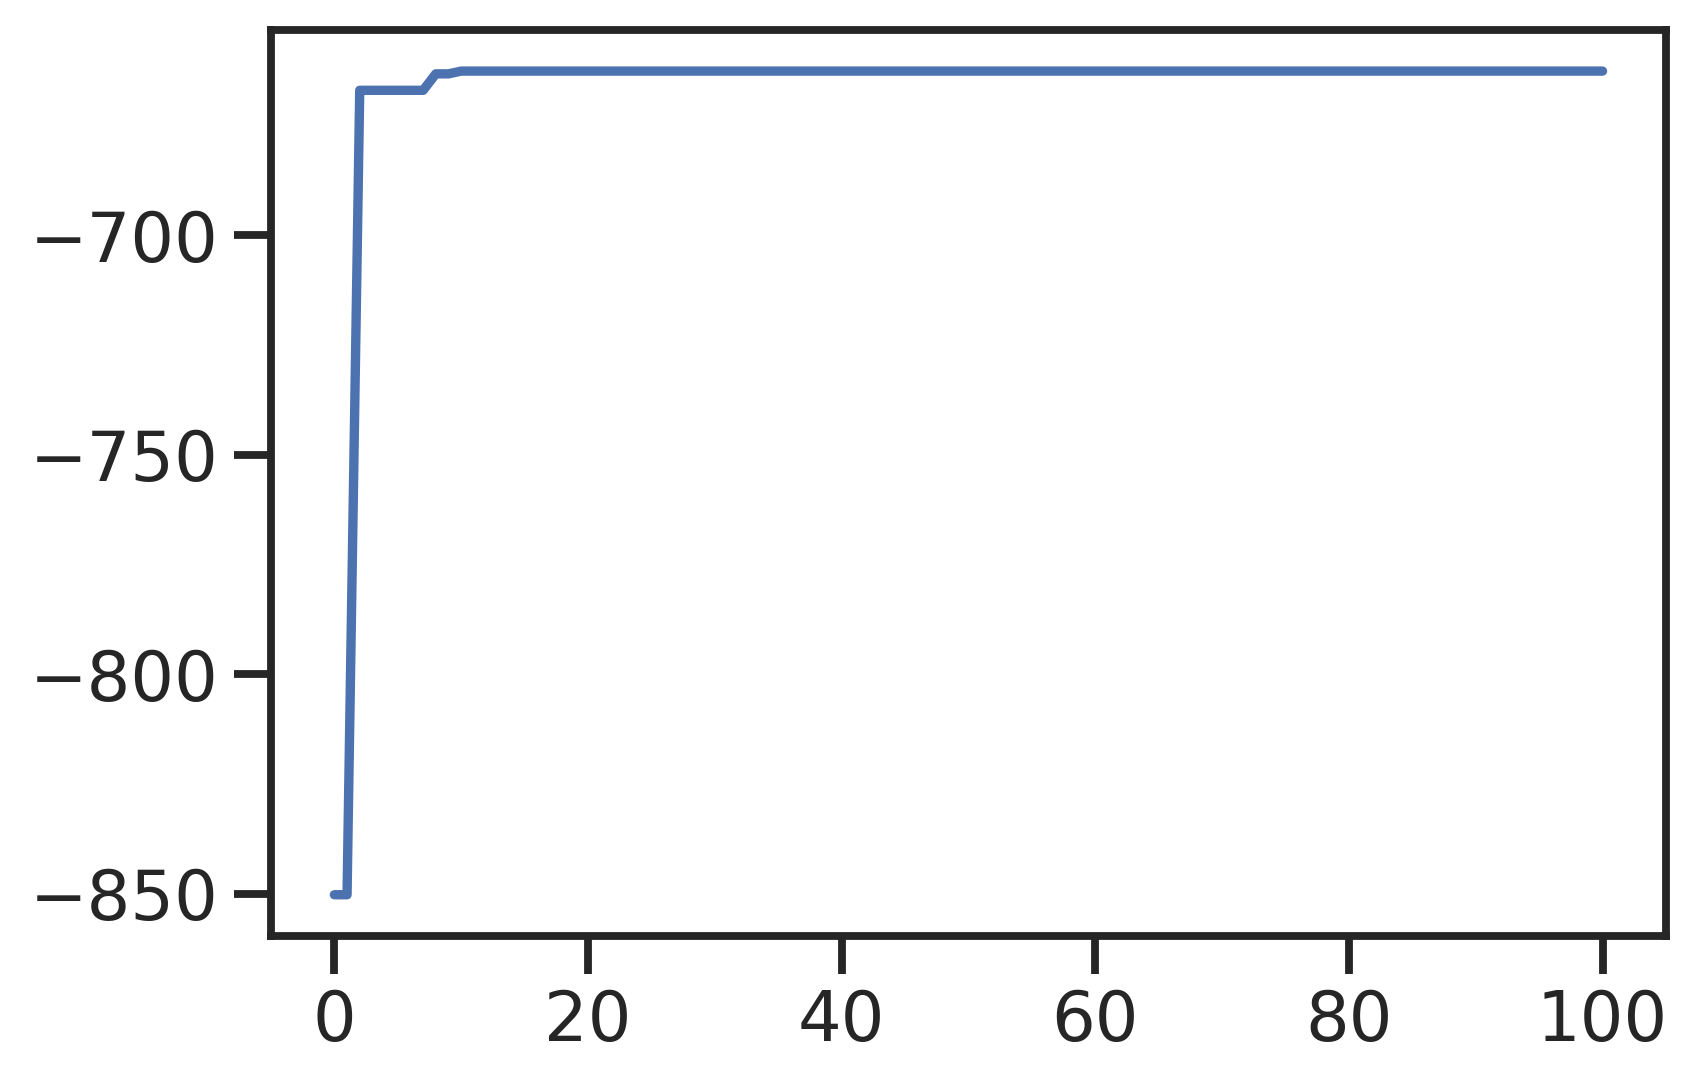

In [115]:
plt.plot(gao.best_fitness_per_generation)

In [116]:
AIC_ps = 2*len(fit_parms) + fit_cost
AIC_ps

666.5410960422103

In [117]:
fragments = particle_split(sample_sizes, fit_parms[0], int(fit_parms[1]))
frag_freq = fragment_frequency(fragments)

(0, 50)

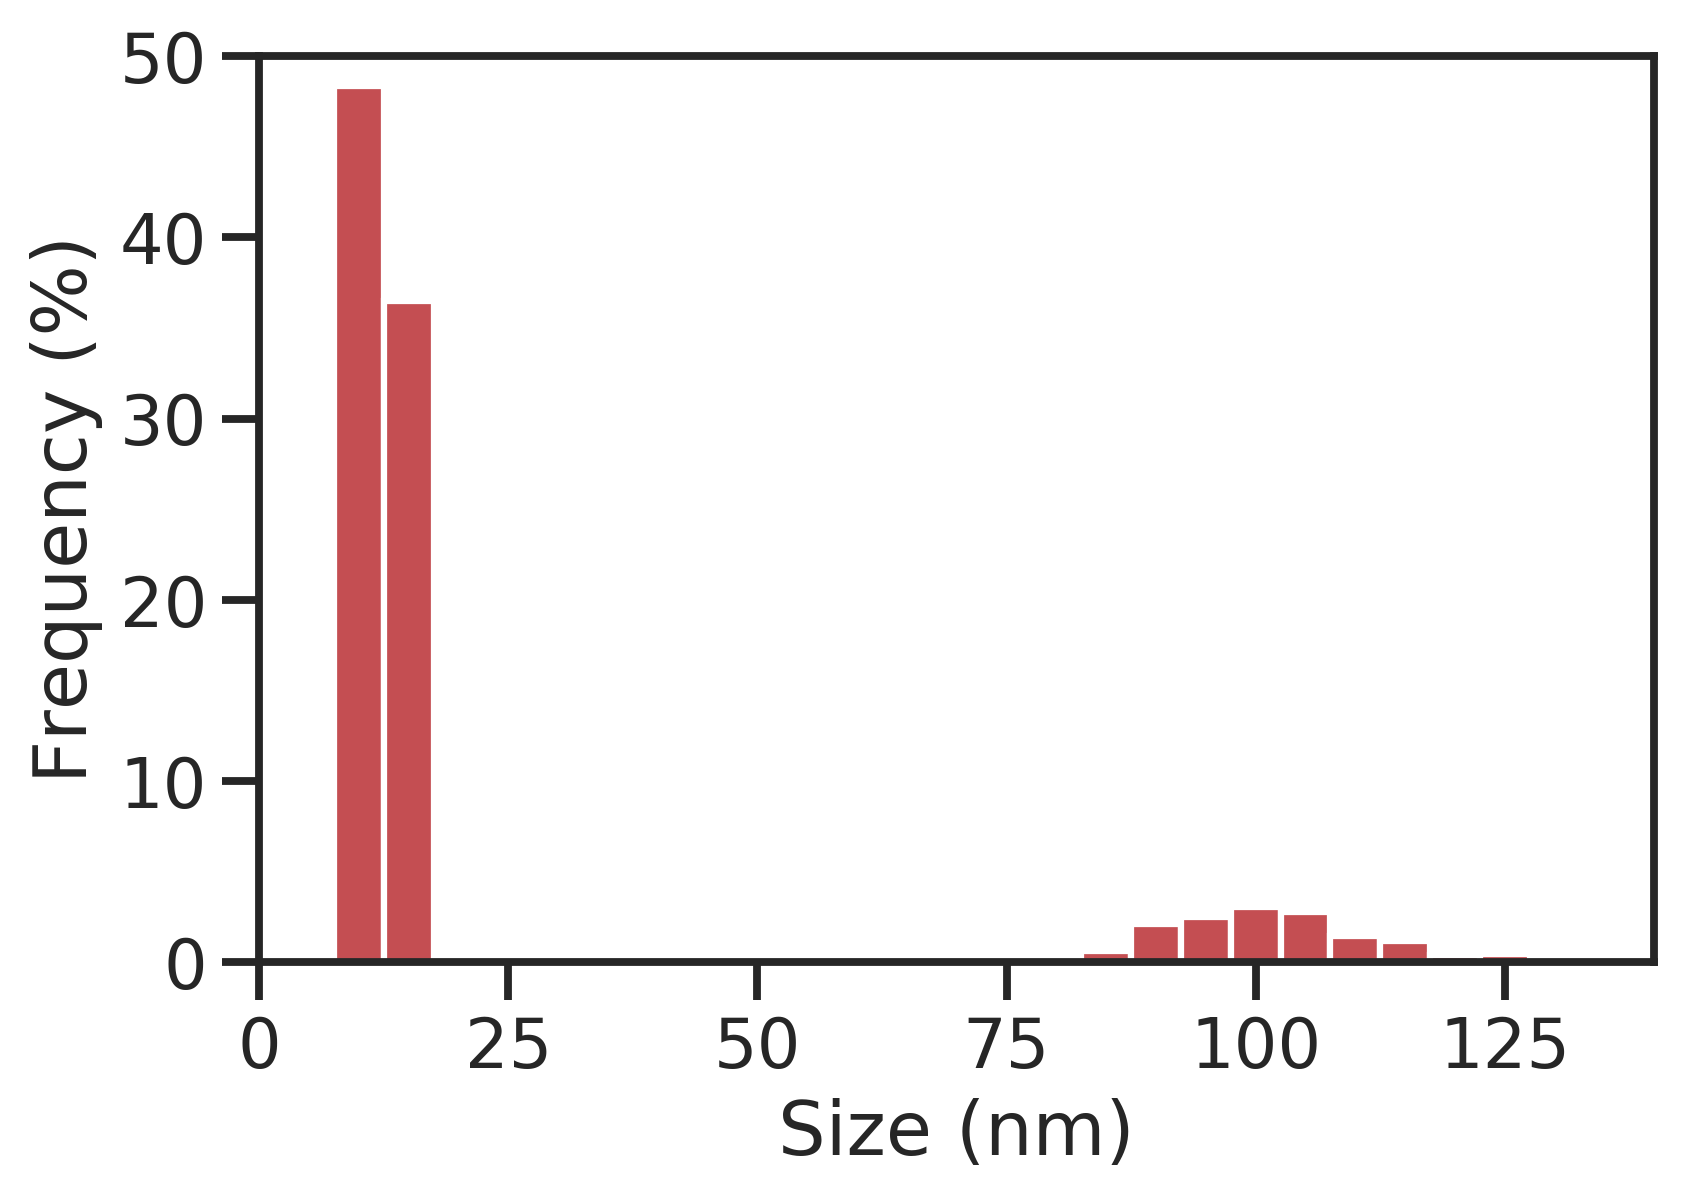

In [118]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,50))

In [119]:
np.savetxt('100nm_nlsfit_frequency_ps.txt', frag_freq)

Text(20, 44, 'SSE=663')

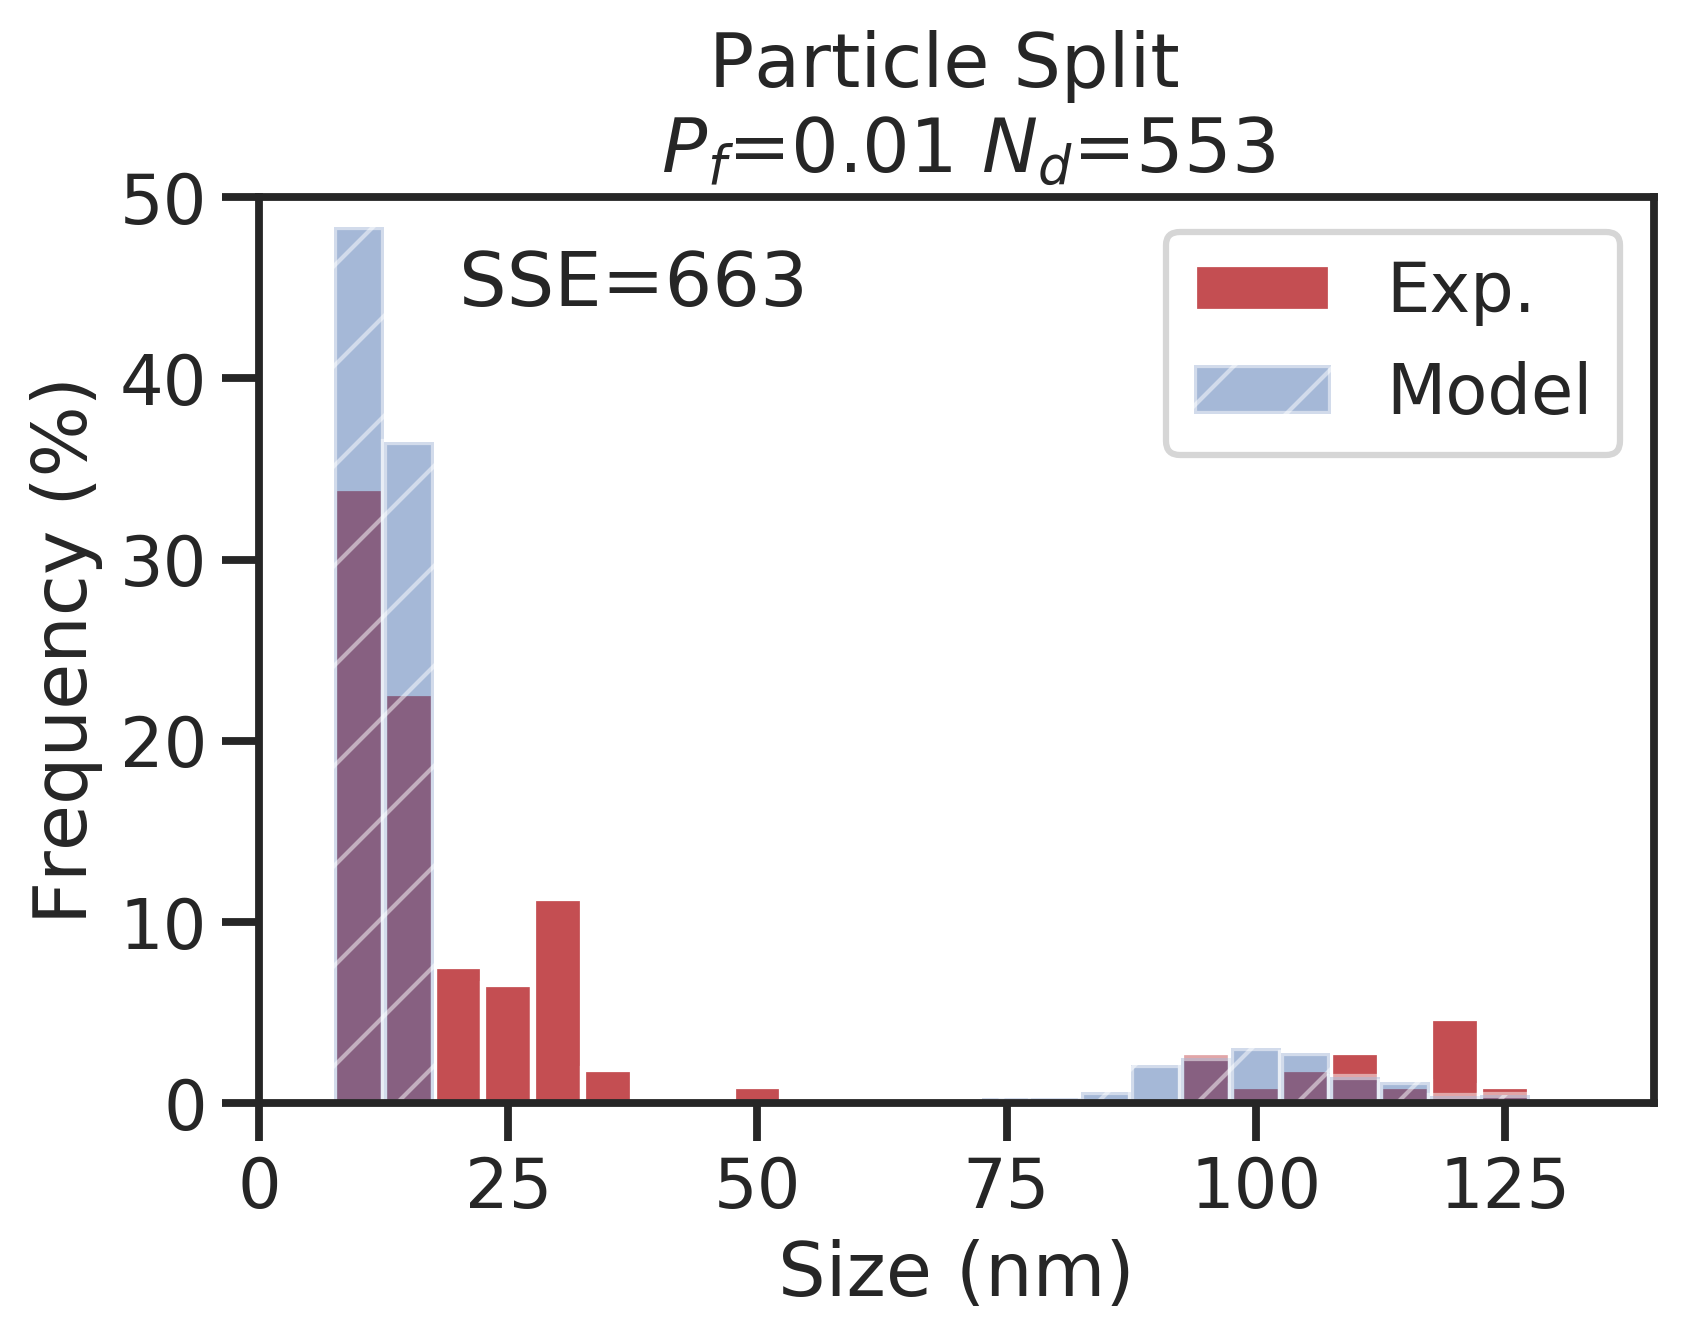

In [120]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,50))
plt.title("Particle Split \n $P_f$={:.2f} $N_d$={}".format(fit_parms[0], int(fit_parms[1])))
plt.text(20,44, "SSE={:.0f}".format(fit_cost))

## Surface Layer Ablation, Unequal - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [ ]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [ ]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

In [159]:
import galibrate as gal

In [161]:
gal.__path__

['/home/blake/src/python/GAlibrate/galibrate']

In [180]:
#nrepeats = 3
# Set the active point population size
population_size = 400
#fit_parms_rep = list()
#fit_cost_rep = list()
#for rep in range(nrepeats):
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation_unequal, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run(nprocs=2)
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)
#    fit_parms_rep.append(fit_parms)
#    fit_cost_rep.append(fit_cost)
#fit_parms_rep = np.array(fit_parms_rep)
#fit_cost_rep = np.array(fit_cost_rep)
#fit_parms = fit_parms_rep.mean(axis=0)
#fit_parms_err = fit_parms_rep.std(axis=0)/np.sqrt(nrepeats)
#fit_cost = fit_cost_rep.mean()
#print(fit_parms, fit_parms_err, fit_cost)

Generations: 100%|██████████| 100/100 [04:23<00:00,  2.63s/it]


[4.30356322e-02 9.27869557e-02 9.32994240e+01] 364.48903201476884


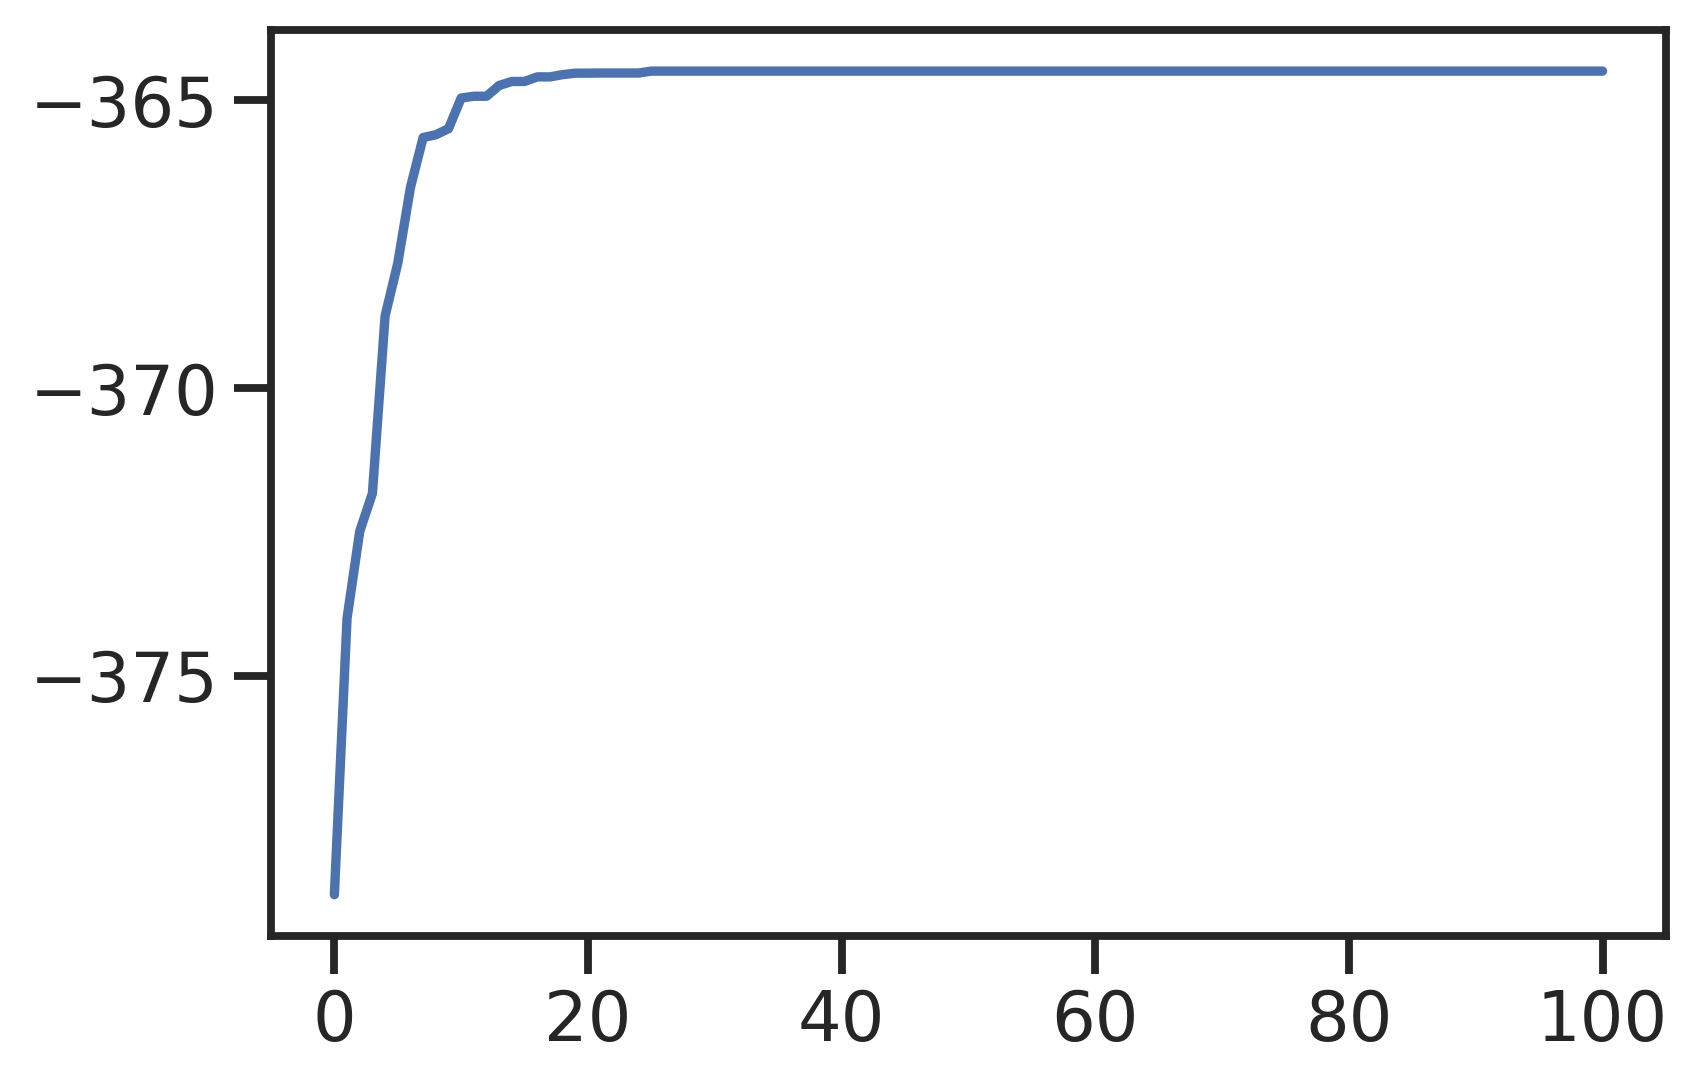

In [181]:
plt.plot(gao.best_fitness_per_generation)

In [182]:
AIC_sa_ue = 2*len(fit_parms) + fit_cost
AIC_sa_ue

370.48903201476884

In [183]:
fragments = surface_ablation_unequal(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

In [184]:
#plt.hist(centers, bins=edges, weights=frag_freq, color='r')
#plt.xlim((0,10))
#plt.ylabel("Frequency (%)")
#plt.xlabel("Size (nm)")
#plt.ylim((0,25))

Text(20, 44, 'SSE=364')

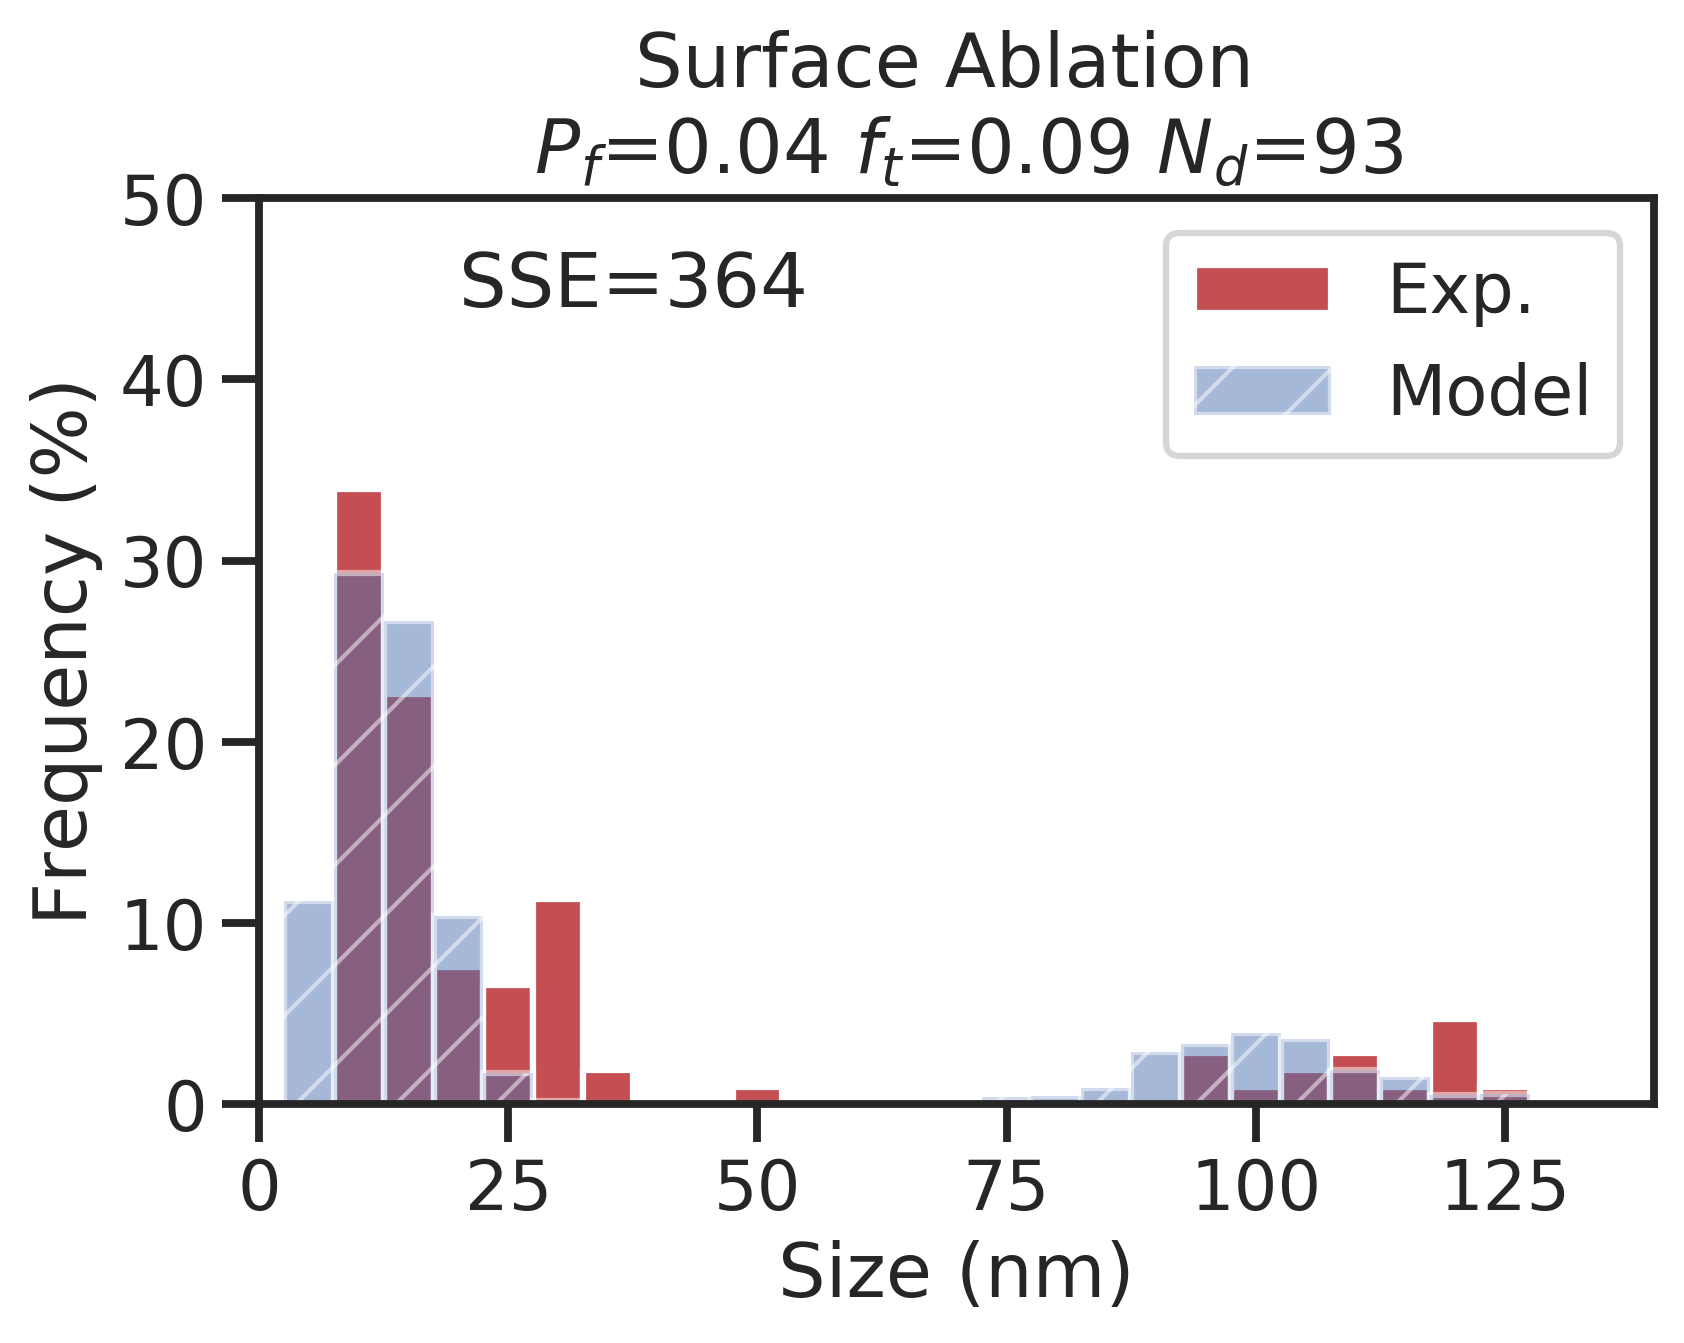

In [185]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,50))
plt.title("Surface Ablation \n $P_f$={:.2f} $f_t$={:.2f} $N_d$={}".format(fit_parms[0], fit_parms[1], int(fit_parms[2])))
plt.text(20,44, "SSE={:.0f}".format(fit_cost))

## Particle Split, Unequal - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [186]:
# Set the active point population size
population_size = 400
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_ps, fitness_particle_split_unequal, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run(nprocs=2)
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)

Generations: 100%|██████████| 100/100 [05:29<00:00,  3.30s/it]


[1.12970643e-02 3.50752600e+02] 363.9782527485534


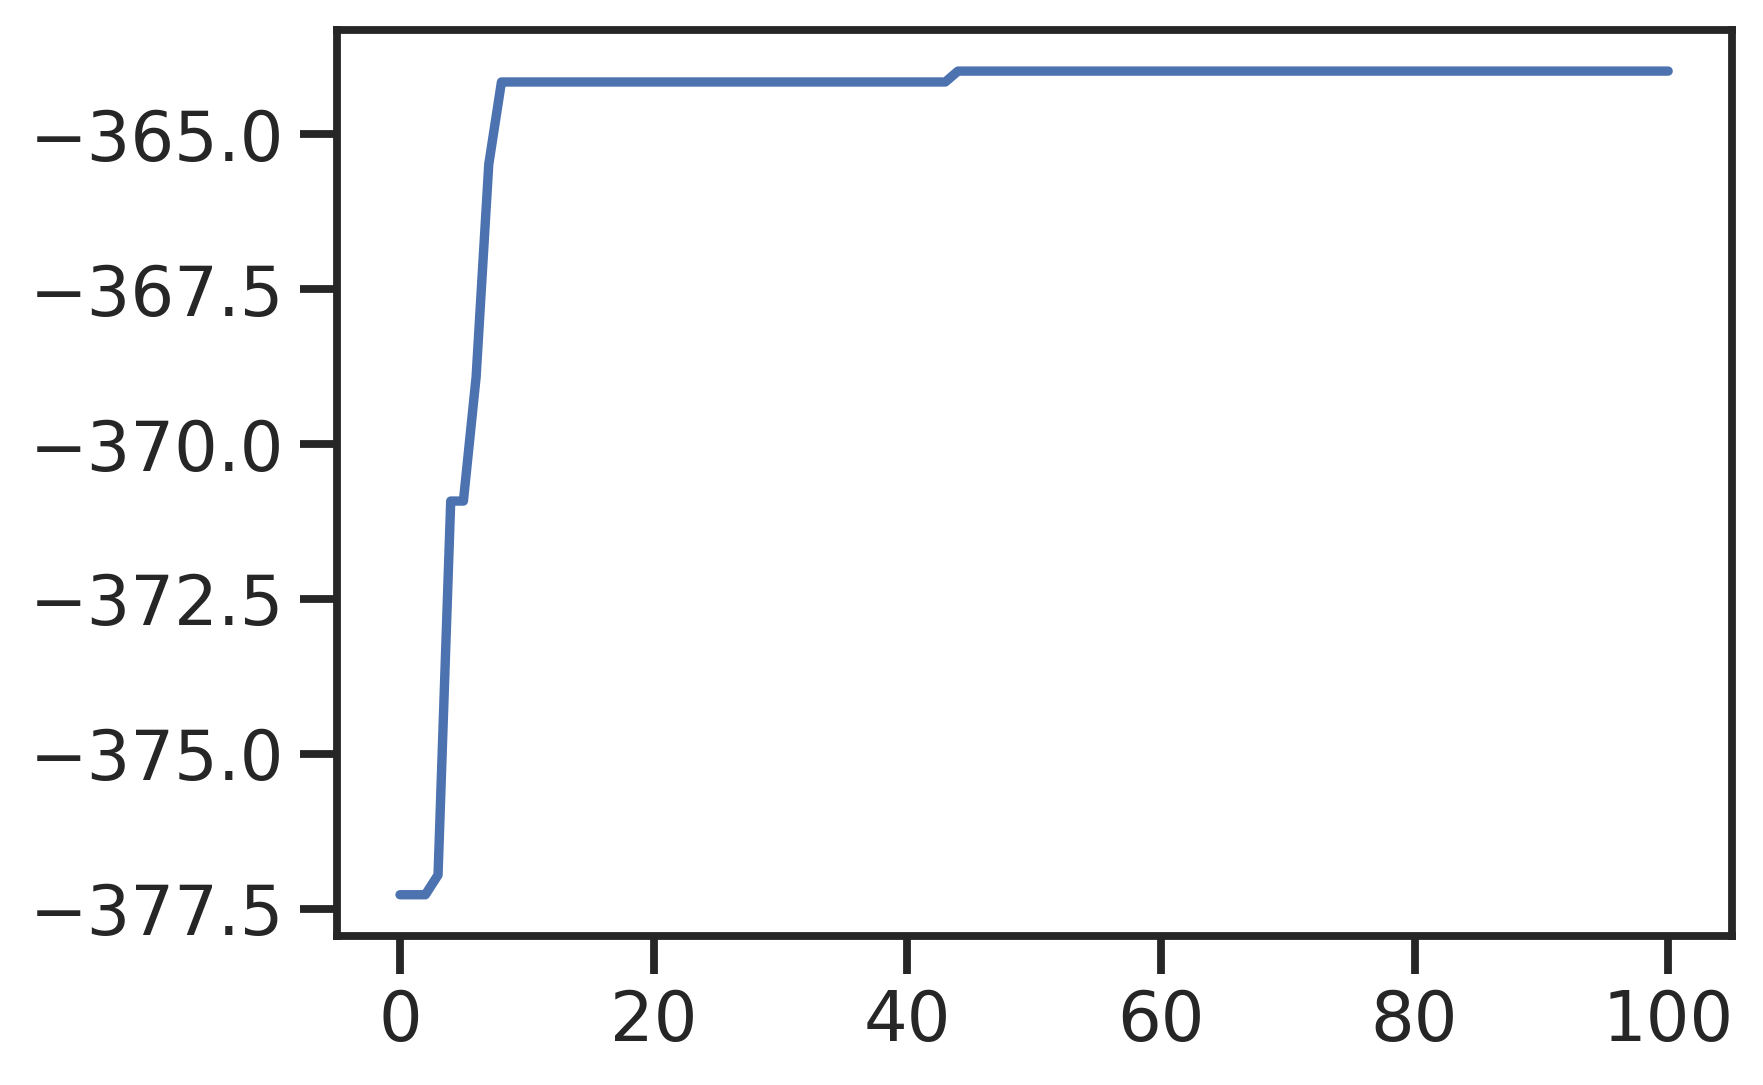

In [187]:
plt.plot(gao.best_fitness_per_generation)

In [188]:
AIC_ps = 2*len(fit_parms) + fit_cost
AIC_ps

367.9782527485534

In [189]:
fragments = particle_split_unequal(sample_sizes, fit_parms[0], int(fit_parms[1]))
frag_freq = fragment_frequency(fragments)

(0, 50)

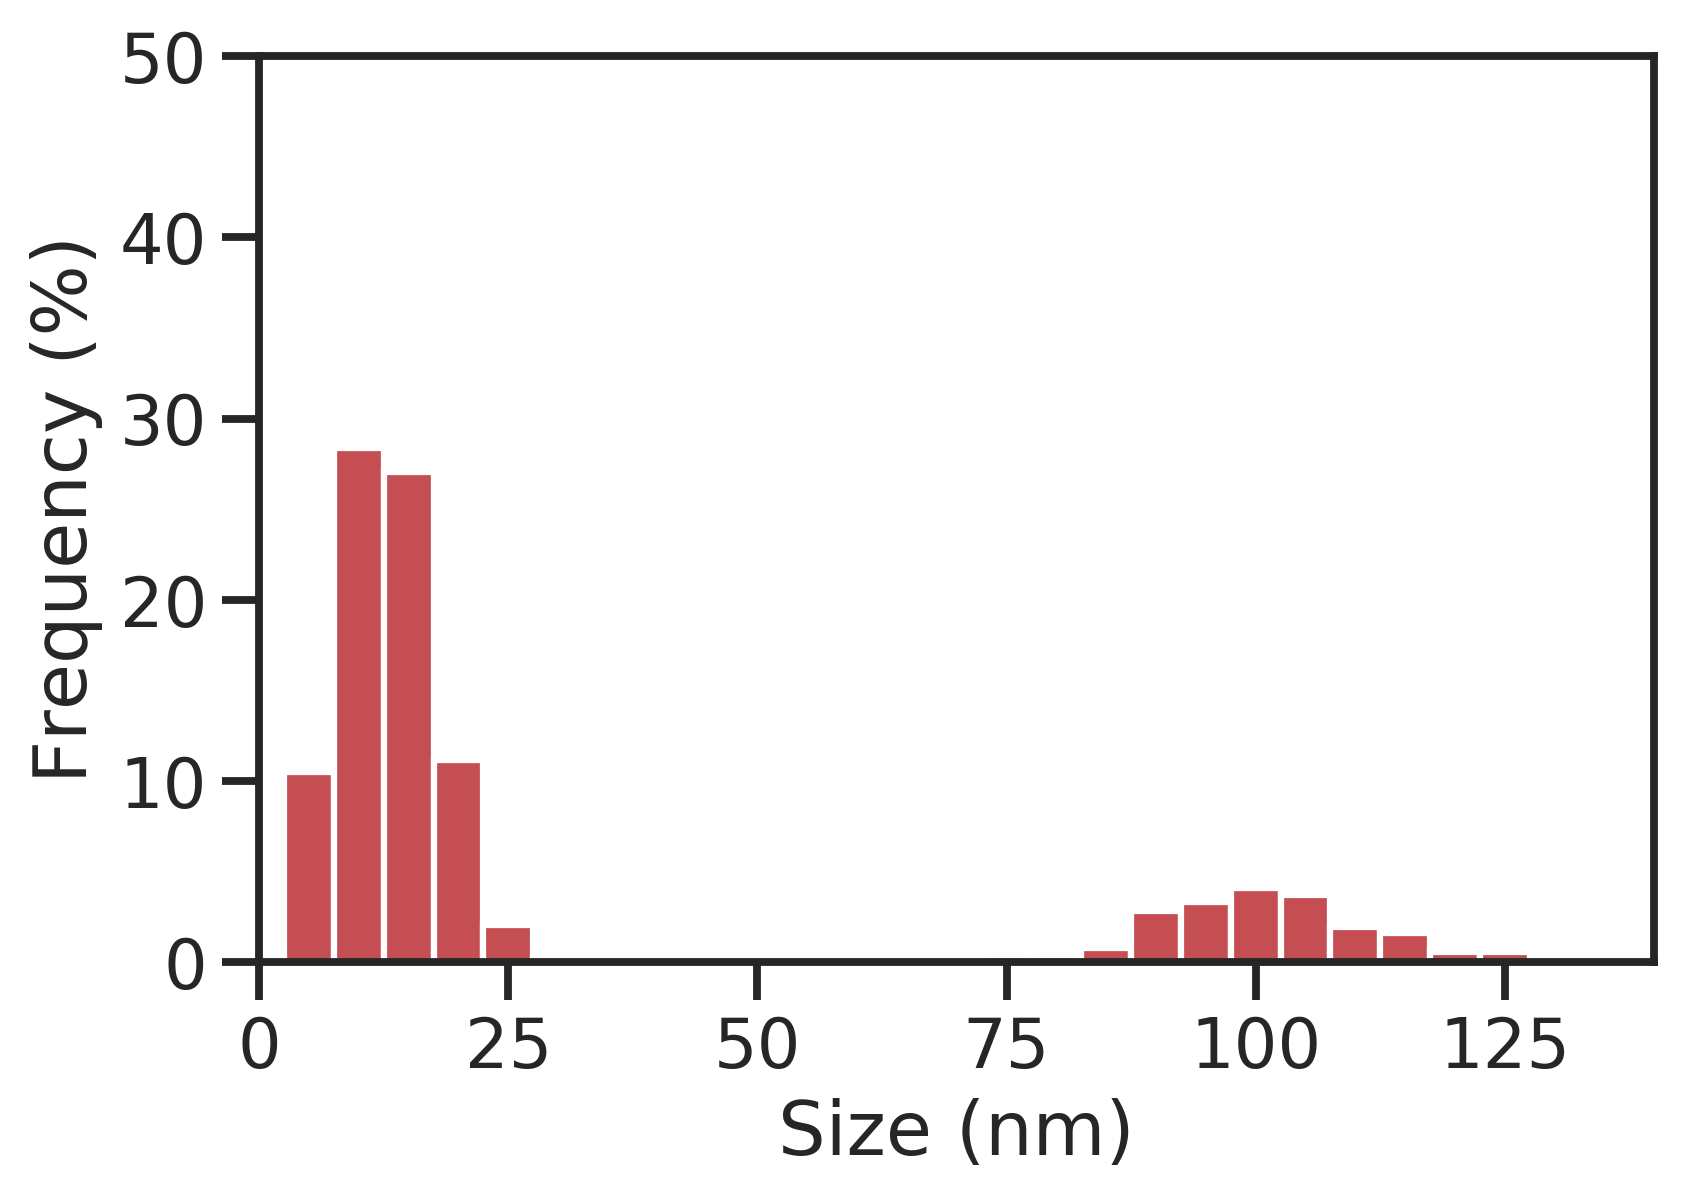

In [190]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,50))

Text(20, 44, 'SSE=364')

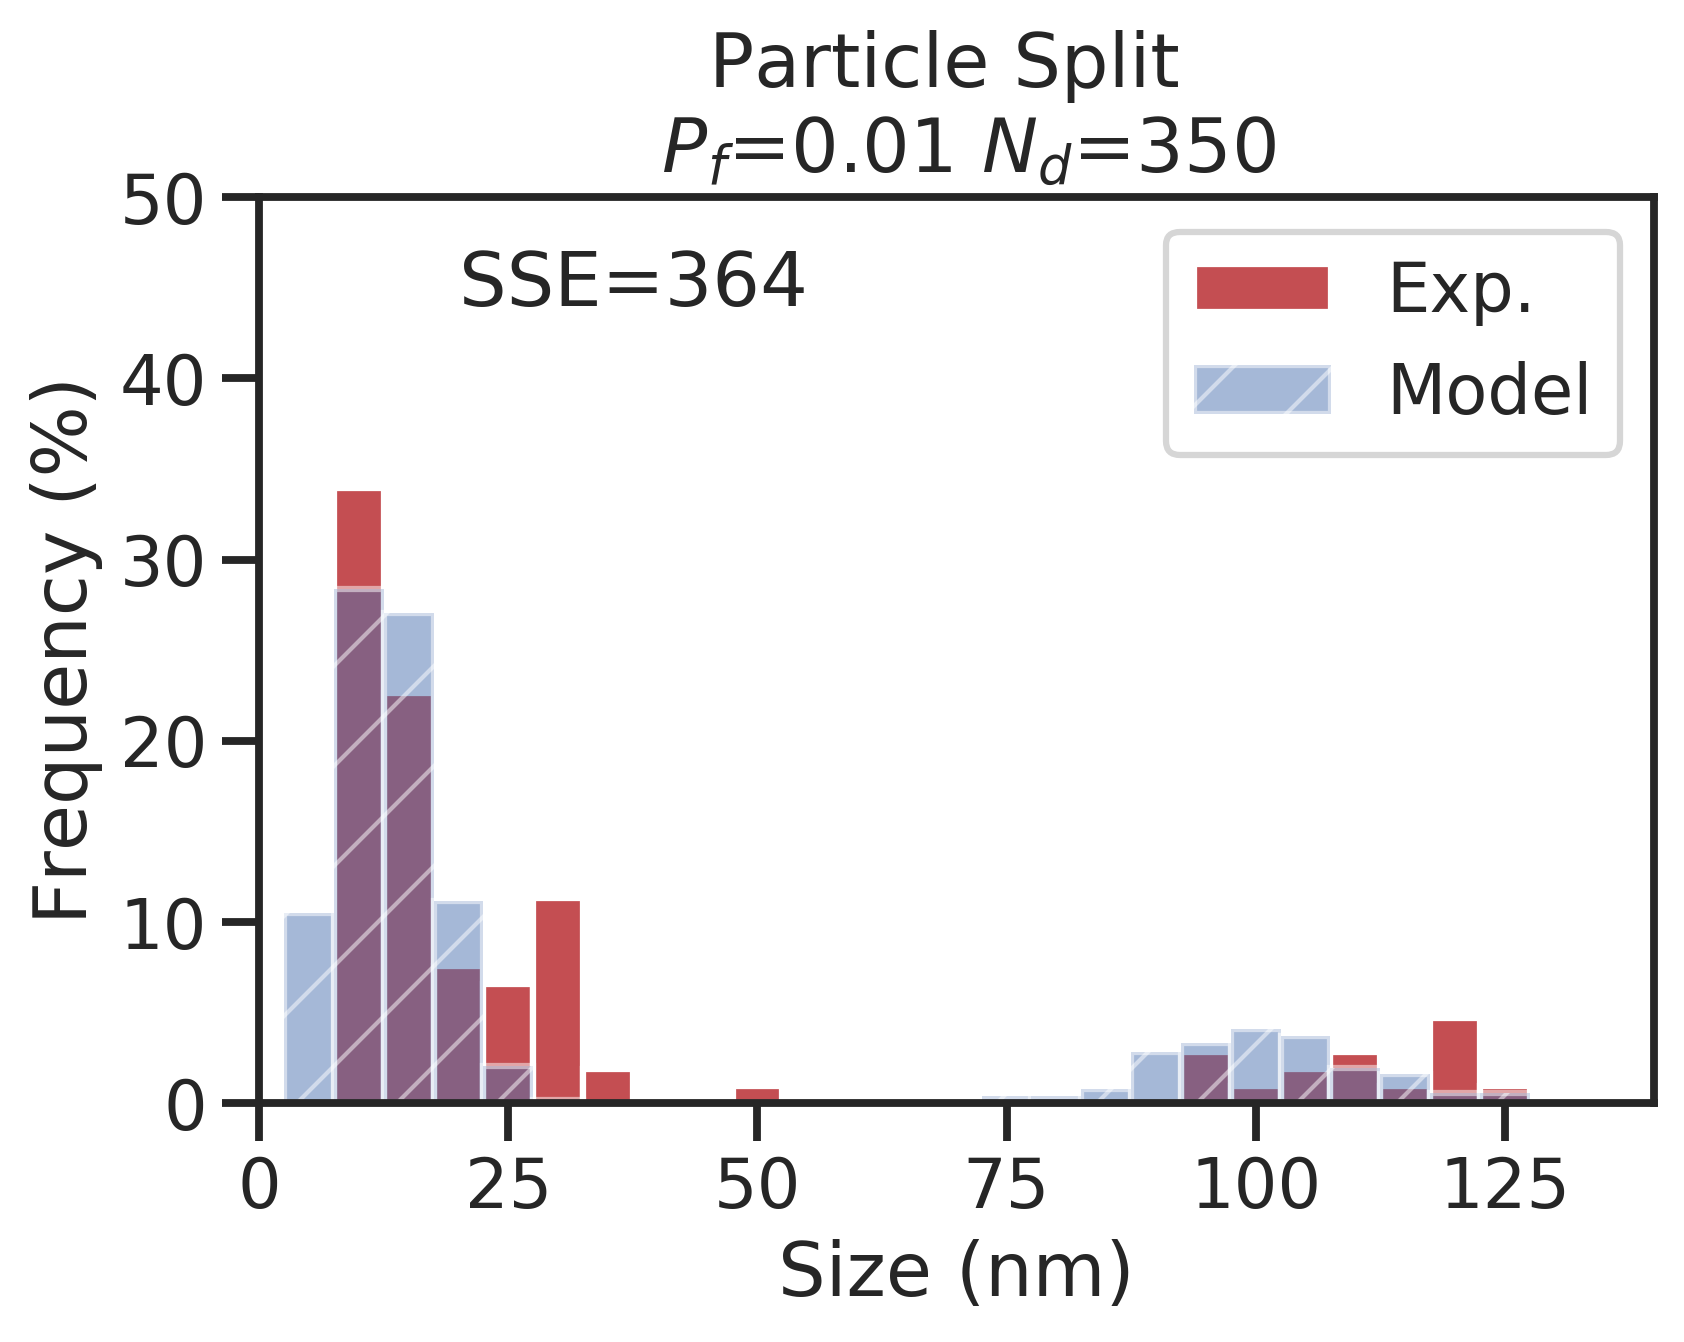

In [191]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,50))
plt.title("Particle Split \n $P_f$={:.2f} $N_d$={}".format(fit_parms[0], int(fit_parms[1])))
plt.text(20,44, "SSE={:.0f}".format(fit_cost))